# White Box Model Exploration

The idea of this section is to explore how good the WB model is, and to decide whether it is possible to make it more accurate

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import json
from config import DATA_DIR, TFO_PARAMETERS_FILE
from scipy.optimize import least_squares

alldf = pd.read_csv('data/final_merged_data_with_wb_pred.csv')

exclude_ids = [76075, 76632]

alldf = alldf[~alldf['equipmentId'].isin(exclude_ids)]

alldf

,Unnamed: 0.1,Unnamed: 0,equipmentId,nominalLoad,locationId,coolingType,manufactureYear,commissioningDate,enclosure,heatRunTest_noLoadLosses,...,heatRunTest_h,heatRunTest_gradient,dateTime,load,hotspotTemperature,temperature,windSpeed,relativeHumidityPercentage,city,wb_pred
0,0,0,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-04-30 23:00:00,10130.00,40.50,12.26,2.05,70.96,Wilsele,NaN
1,1,4,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 00:00:00,9160.97,38.61,11.73,1.60,74.35,Wilsele,25.356879
2,2,8,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 01:00:00,12049.23,38.77,11.35,1.39,77.63,Wilsele,28.064633
3,3,12,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 02:00:00,11077.78,38.67,10.80,1.13,80.86,Wilsele,26.411574
4,4,16,50033827,40.0,26,ONAF1,2008,2010-03-17T00:00:00,1 wall,16.37,...,1.13,11.8,2023-05-01 03:00:00,11093.11,37.92,10.62,1.00,82.36,Wilsele,26.248490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249283,249283,997132,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 18:00:00,15281.92,47.47,3.87,7.27,94.12,Anderlecht,41.547430
249284,249284,997136,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 19:00:00,14497.30,48.05,4.15,7.33,93.61,Anderlecht,39.675514
249285,249285,997140,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 20:00:00,13493.01,47.65,4.28,7.48,92.85,Anderlecht,37.123920
249286,249286,997144,50249457,25.0,2,ONAF1,2011,2016-04-15T00:00:00,4 walls,9.50,...,1.10,14.4,2024-12-31 21:00:00,12719.02,46.36,4.61,8.14,93.20,Anderlecht,35.446373


In [22]:
# Count of rows with hotspotTemperature 0
(alldf['hotspotTemperature'] == 0).sum()

np.int64(0)

In [25]:
def eval_wb(df, y_true='hotspotTemperature', y_pred='wb_pred', load_col='load', nominal_load_col='nominalLoad'):
    d = df[[y_true, y_pred, load_col, nominal_load_col]].dropna().copy()
    err = d[y_pred] - d[y_true]
    mae  = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    mbe  = np.mean(err)
    # Normalize by IQR of true temps (robust scale)
    iqr = d[y_true].quantile(0.75) - d[y_true].quantile(0.25)
    nrmse_pct = 100 * rmse / (iqr if iqr > 0 else (d[y_true].max()-d[y_true].min()))
    r2 = 1 - np.sum(err**2) / np.sum((d[y_true] - d[y_true].mean())**2)

    # Percentile and max errors (good for risk)
    p95_abs = np.percentile(np.abs(err), 95)
    max_abs = np.max(np.abs(err))

    # Binned metrics by K
    bins = [0, 0.5, 0.9, 1.1, np.inf]
    labels = ["<0.5", "0.5–0.9", "0.9–1.1", ">1.1"]
    d['K_bin'] = pd.cut(d[load_col]/(d[nominal_load_col]*1000), bins=bins, labels=labels, include_lowest=True)
    byK = d.groupby('K_bin').apply(
        lambda g: pd.Series({
            'n': len(g),
            'MAE': np.mean(np.abs(g[y_pred]-g[y_true])),
            'RMSE': np.sqrt(np.mean((g[y_pred]-g[y_true])**2)),
            'Bias': np.mean(g[y_pred]-g[y_true])
        })
    )

    return {
        'MAE': mae, 'RMSE': rmse, 'Bias': mbe,
        'NRMSE%_IQR': nrmse_pct, 'R2': r2,
        'P95_abs_err': p95_abs, 'Max_abs_err': max_abs,
        'by_K_bin': byK
    }

# Example usage:
# results = eval_wb(df)  # df must have temp_meas, wb_pred, K
# print(results)


In [23]:
eval_results = eval_wb(alldf)
eval_results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\4117572504.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\4117572504.py:23: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.545723646063696),
 'RMSE': np.float64(9.101360473733653),
 'Bias': np.float64(-7.1579483211514985),
 'NRMSE%_IQR': np.float64(60.91941414815028),
 'R2': np.float64(0.43103795374704923),
 'P95_abs_err': np.float64(16.950794539915538),
 'Max_abs_err': np.float64(102.62035619691665),
 'by_K_bin':                 n       MAE       RMSE      Bias
 K_bin                                           
 <0.5     183404.0  7.310829   8.842928 -6.954073
 0.5–0.9   23173.0  9.411280  11.031613 -8.615603
 0.9–1.1     407.0  8.490335   9.412346 -8.208187
 >1.1          0.0       NaN        NaN       NaN}

## Problems with the data

- Sometimes ambient T is missing
- Sometimes hotspot T goes to negative values or shoots up (e.g. 5030256)
![image](figures/notebooks/hotspot_t_shoots_up_or_down.png)
- Sometimes, when there is no load, the transformer has a voltage and sometimes it doesn't. In this picture it's clear when the transformer is energized
![image](figures/notebooks/energized_vs_non_energized_without_load.png)

# Possible Improvements

- $R = \frac{P_{cu}}{(1-s) P_{no\_loss}}$, with $s \approx 0.1$

- $ K = \frac{S_{load}}{S_{rated}} = \frac{P}{PF \dot S_{rated}} $ where PF is the Power Factor as $ PF = cos(\phi) $ and $\phi$ is the phase shift between current and voltage. $ PF \approx 0.9$

- When load is 0, $ T_{wb\_pred} \neq T_{amb} $

In [ ]:
def white_box_model(theta_a, delta_top_oil, delta_hotspot, x_param, y_param, R=0.1, K=0.05):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + K ** y_param * (delta_hotspot - delta_top_oil) + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_deltaHotspot'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [67]:
# Here it uses the gradient column instead of delta_hotspot - delta_top_oil

def white_box_model(theta_a, delta_top_oil, gradient, x_param, y_param, R=0.1, K=0.05):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + K ** y_param * gradient + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_gradient'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [68]:
df = wb_preds_for_df(alldf)
results = eval_wb(df)
results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.898856894776845),
 'RMSE': np.float64(9.460494431035835),
 'Bias': np.float64(-7.567956896965914),
 'NRMSE%_IQR': np.float64(61.47169870718541),
 'R2': np.float64(0.40492325355711667),
 'P95_abs_err': np.float64(17.477422137299286),
 'Max_abs_err': np.float64(101.77319554694921),
 'by_K_bin':                 n        MAE       RMSE      Bias
 K_bin                                            
 <0.5     183419.0   7.606125   9.119759 -7.296244
 0.5–0.9   23173.0  10.179606  11.794978 -9.679414
 0.9–1.1     407.0   9.964445  10.835804 -9.800322
 >1.1          0.0        NaN        NaN       NaN}

In [70]:
# Here i am including h also

def white_box_model(theta_a, delta_top_oil, gradient, x_param, y_param, h, R, K):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + h * K ** y_param * gradient + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, gradient, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_gradient'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['heatRunTest_h'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [71]:
df = wb_preds_for_df(alldf)
results = eval_wb(df)
results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.544876263386686),
 'RMSE': np.float64(9.111367094685729),
 'Bias': np.float64(-7.139613037629815),
 'NRMSE%_IQR': np.float64(59.20316500770454),
 'R2': np.float64(0.44803390672794474),
 'P95_abs_err': np.float64(16.97595508225528),
 'Max_abs_err': np.float64(102.64456078691572),
 'by_K_bin':                 n       MAE       RMSE      Bias
 K_bin                                           
 <0.5     183419.0  7.308531   8.840195 -6.952039
 0.5–0.9   23173.0  9.399365  11.020755 -8.605957
 0.9–1.1     407.0  8.468951   9.391011 -8.183873
 >1.1          0.0       NaN        NaN       NaN}

In [72]:
# Lastly I am using h but also (delta_hotspot - delta_top_oil)

def white_box_model(theta_a, delta_top_oil, delta_hotspot, x_param, y_param, h, R, K):
    #theta_a = x[:, 3]  # ambient temperature
    #delta_top_oil = x[:, 4]  # delta top oil
    #delta_hotspot = x[:, -2]  # heat run test y (assumption)
    #x_param = x[:, -3]  # heat run test x (assumption)
    #y_param = x[:, -1]  # heat run test gradient (assumption)

    white_box_pred = ((1 + R * K ** 2) / (1 + R)) ** x_param * \
                     delta_top_oil + h * K ** y_param * (delta_hotspot - delta_top_oil) + theta_a
    return white_box_pred

def get_wb_prediction_naive(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss):
    R = 0.1
    K = load / (nominal_load * 1000)  # Convert kW to W
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def get_wb_prediction_pro(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, load, nominal_load, copper_loss, no_load_loss, s, pf):
    R = copper_loss / ((1 - s) * no_load_loss)  # s is approx 0.1
    K = load / (pf * nominal_load * 1000)  # Convert MW to kW, pf is power factor approx 0.9
    wb_pred = white_box_model(ambient, delta_top_oil, delta_hotspot, heat_run_test_x, heat_run_test_y, heat_run_test_h, R, K)
    return wb_pred

def wb_preds_for_df(df, s = None, pf = None):
    df = df.copy()
    df['wb_pred'] = get_wb_prediction_pro(
        df['temperature'],
        df['heatRunTest_deltaTopOil'],
        df['heatRunTest_deltaHotspot'],
        df['heatRunTest_x'],
        df['heatRunTest_y'],
        df['heatRunTest_h'],
        df['load'],
        df['nominalLoad'],
        df['heatRunTest_copperLosses'],
        df['heatRunTest_noLoadLosses'],
        s = 0 if s is None else s,
        pf = 1 if pf is None else pf
    )
    return df

In [73]:
df = wb_preds_for_df(alldf)
results = eval_wb(df)
results

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(


{'MAE': np.float64(7.156129355842767),
 'RMSE': np.float64(8.737205320892862),
 'Bias': np.float64(-6.62184851010227),
 'NRMSE%_IQR': np.float64(56.77196439826421),
 'R2': np.float64(0.49243648744657387),
 'P95_abs_err': np.float64(16.47001790777963),
 'Max_abs_err': np.float64(103.5764375018799),
 'by_K_bin':                 n       MAE       RMSE      Bias
 K_bin                                           
 <0.5     183419.0  6.968196   8.527692 -6.529281
 0.5–0.9   23173.0  8.649082  10.257658 -7.358758
 0.9–1.1     407.0  6.847515   7.881779 -6.381571
 >1.1          0.0       NaN        NaN       NaN}

**Result**

The best results are achieved (when using the parameters from the dataset) using hotspot-oil and h simultaneously.

C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=1 -> MAE=5.66, RMSE=7.32, Bias=-4.50, R2=0.644
s=-0.6, pf=0.95 -> MAE=5.24, RMSE=6.84, Bias=-3.75, R2=0.689


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=0.9 -> MAE=4.91, RMSE=6.44, Bias=-2.89, R2=0.724
s=-0.6, pf=0.85 -> MAE=4.75, RMSE=6.24, Bias=-1.90, R2=0.741


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=0.8 -> MAE=4.82, RMSE=6.36, Bias=-0.74, R2=0.731
s=-0.6, pf=0.75 -> MAE=5.19, RMSE=6.97, Bias=0.62, R2=0.677


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.6, pf=0.7 -> MAE=5.91, RMSE=8.18, Bias=2.23, R2=0.555
s=-0.8, pf=1 -> MAE=5.32, RMSE=6.97, Bias=-3.86, R2=0.677


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.8, pf=0.95 -> MAE=4.96, RMSE=6.53, Bias=-3.13, R2=0.717
s=-0.8, pf=0.9 -> MAE=4.69, RMSE=6.19, Bias=-2.28, R2=0.745


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-0.8, pf=0.85 -> MAE=4.60, RMSE=6.06, Bias=-1.30, R2=0.756
s=-0.8, pf=0.8 -> MAE=4.74, RMSE=6.27, Bias=-0.17, R2=0.739


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-0.8, pf=0.75 -> MAE=5.17, RMSE=6.96, Bias=1.17, R2=0.678
s=-0.8, pf=0.7 -> MAE=5.95, RMSE=8.22, Bias=2.76, R2=0.550
s=-1, pf=1 -> MAE=5.05, RMSE=6.68, Bias=-3.26, R2=0.703


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1, pf=0.95 -> MAE=4.75, RMSE=6.28, Bias=-2.53, R2=0.738
s=-1, pf=0.9 -> MAE=4.54, RMSE=6.00, Bias=-1.70, R2=0.760
s=-1, pf=0.85 -> MAE=4.50, RMSE=5.94, Bias=-0.74, R2=0.765


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1, pf=0.8 -> MAE=4.71, RMSE=6.23, Bias=0.38, R2=0.742
s=-1, pf=0.75 -> MAE=5.20, RMSE=6.99, Bias=1.70, R2=0.675
s=-1, pf=0.7 -> MAE=6.03, RMSE=8.31, Bias=3.26, R2=0.541


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.2, pf=1 -> MAE=4.85, RMSE=6.44, Bias=-2.67, R2=0.724
s=-1.2, pf=0.95 -> MAE=4.59, RMSE=6.09, Bias=-1.96, R2=0.753


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.2, pf=0.9 -> MAE=4.44, RMSE=5.87, Bias=-1.14, R2=0.771
s=-1.2, pf=0.85 -> MAE=4.46, RMSE=5.88, Bias=-0.20, R2=0.770


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.2, pf=0.8 -> MAE=4.72, RMSE=6.24, Bias=0.91, R2=0.741
s=-1.2, pf=0.75 -> MAE=5.27, RMSE=7.06, Bias=2.20, R2=0.668
s=-1.2, pf=0.7 -> MAE=6.14, RMSE=8.42, Bias=3.75, R2=0.529


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.4, pf=1 -> MAE=4.71, RMSE=6.26, Bias=-2.12, R2=0.740
s=-1.4, pf=0.95 -> MAE=4.50, RMSE=5.96, Bias=-1.41, R2=0.764


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.4, pf=0.9 -> MAE=4.40, RMSE=5.80, Bias=-0.61, R2=0.776
s=-1.4, pf=0.85 -> MAE=4.47, RMSE=5.88, Bias=0.32, R2=0.770


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.4, pf=0.8 -> MAE=4.78, RMSE=6.30, Bias=1.41, R2=0.736
s=-1.4, pf=0.75 -> MAE=5.37, RMSE=7.17, Bias=2.69, R2=0.658
s=-1.4, pf=0.7 -> MAE=6.29, RMSE=8.55, Bias=4.21, R2=0.514


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.6, pf=1 -> MAE=4.62, RMSE=6.13, Bias=-1.58, R2=0.751
s=-1.6, pf=0.95 -> MAE=4.45, RMSE=5.88, Bias=-0.89, R2=0.770
s=-1.6, pf=0.9 -> MAE=4.40, RMSE=5.78, Bias=-0.10, R2=0.778


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.6, pf=0.85 -> MAE=4.52, RMSE=5.92, Bias=0.82, R2=0.767
s=-1.6, pf=0.8 -> MAE=4.87, RMSE=6.40, Bias=1.90, R2=0.728
s=-1.6, pf=0.75 -> MAE=5.50, RMSE=7.31, Bias=3.16, R2=0.645


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.6, pf=0.7 -> MAE=6.46, RMSE=8.71, Bias=4.66, R2=0.496
s=-1.8, pf=1 -> MAE=4.57, RMSE=6.04, Bias=-1.07, R2=0.757


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.8, pf=0.95 -> MAE=4.45, RMSE=5.84, Bias=-0.39, R2=0.773
s=-1.8, pf=0.9 -> MAE=4.43, RMSE=5.80, Bias=0.40, R2=0.776
s=-1.8, pf=0.85 -> MAE=4.60, RMSE=6.00, Bias=1.30, R2=0.761


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-1.8, pf=0.8 -> MAE=5.00, RMSE=6.53, Bias=2.36, R2=0.717
s=-1.8, pf=0.75 -> MAE=5.66, RMSE=7.47, Bias=3.61, R2=0.629


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will 

s=-1.8, pf=0.7 -> MAE=6.65, RMSE=8.88, Bias=5.09, R2=0.476
s=-2, pf=1 -> MAE=4.57, RMSE=6.00, Bias=-0.58, R2=0.761
s=-2, pf=0.95 -> MAE=4.48, RMSE=5.85, Bias=0.10, R2=0.772


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-2, pf=0.9 -> MAE=4.51, RMSE=5.86, Bias=0.87, R2=0.771
s=-2, pf=0.85 -> MAE=4.71, RMSE=6.11, Bias=1.77, R2=0.752
s=-2, pf=0.8 -> MAE=5.15, RMSE=6.68, Bias=2.81, R2=0.703


C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  byK = d.groupby('K_bin').apply(
C:\Users\Mario\AppData\Local\Temp\ipykernel_15024\809233785.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behav

s=-2, pf=0.75 -> MAE=5.85, RMSE=7.64, Bias=4.04, R2=0.612
s=-2, pf=0.7 -> MAE=6.86, RMSE=9.06, Bias=5.51, R2=0.454

Saved grid results to wb_full_eval_grid.csv


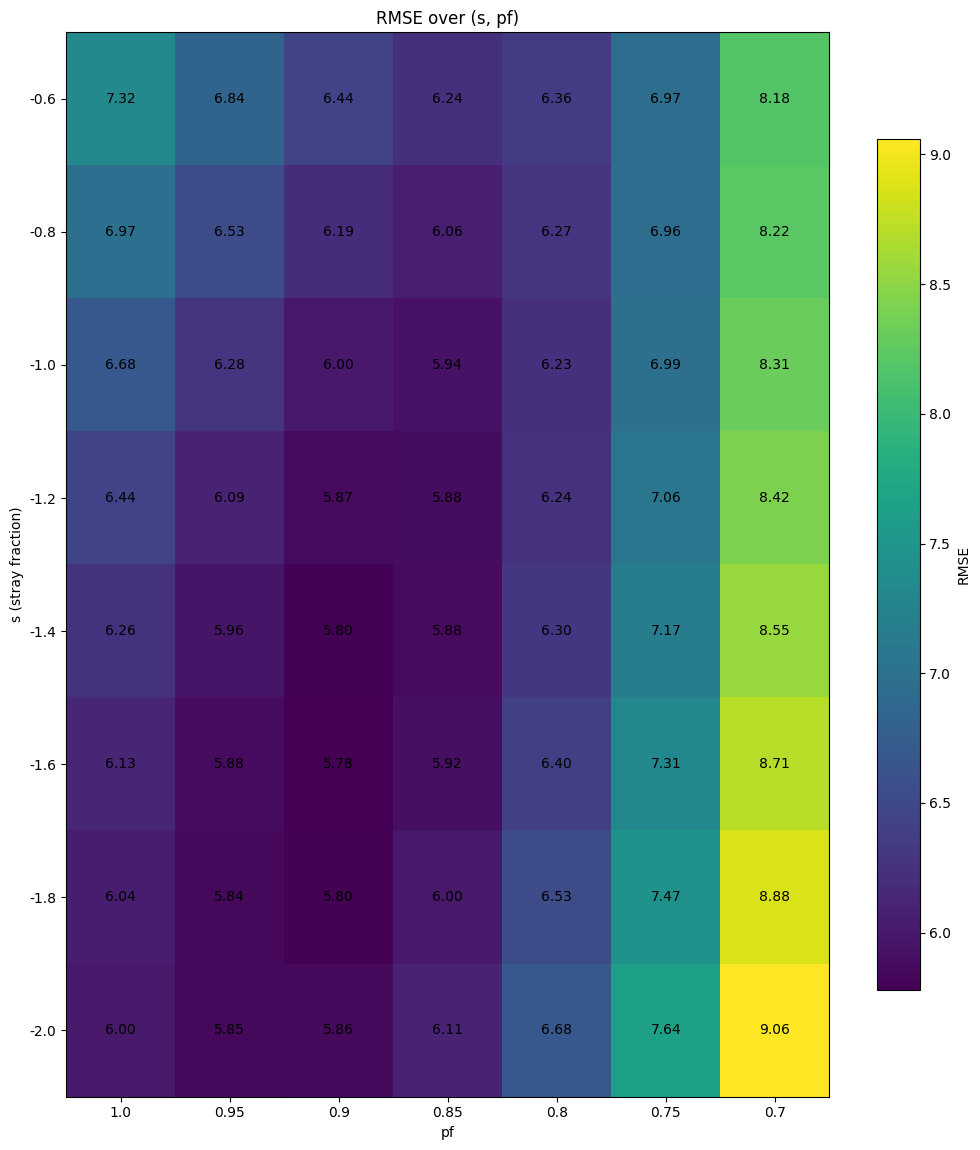

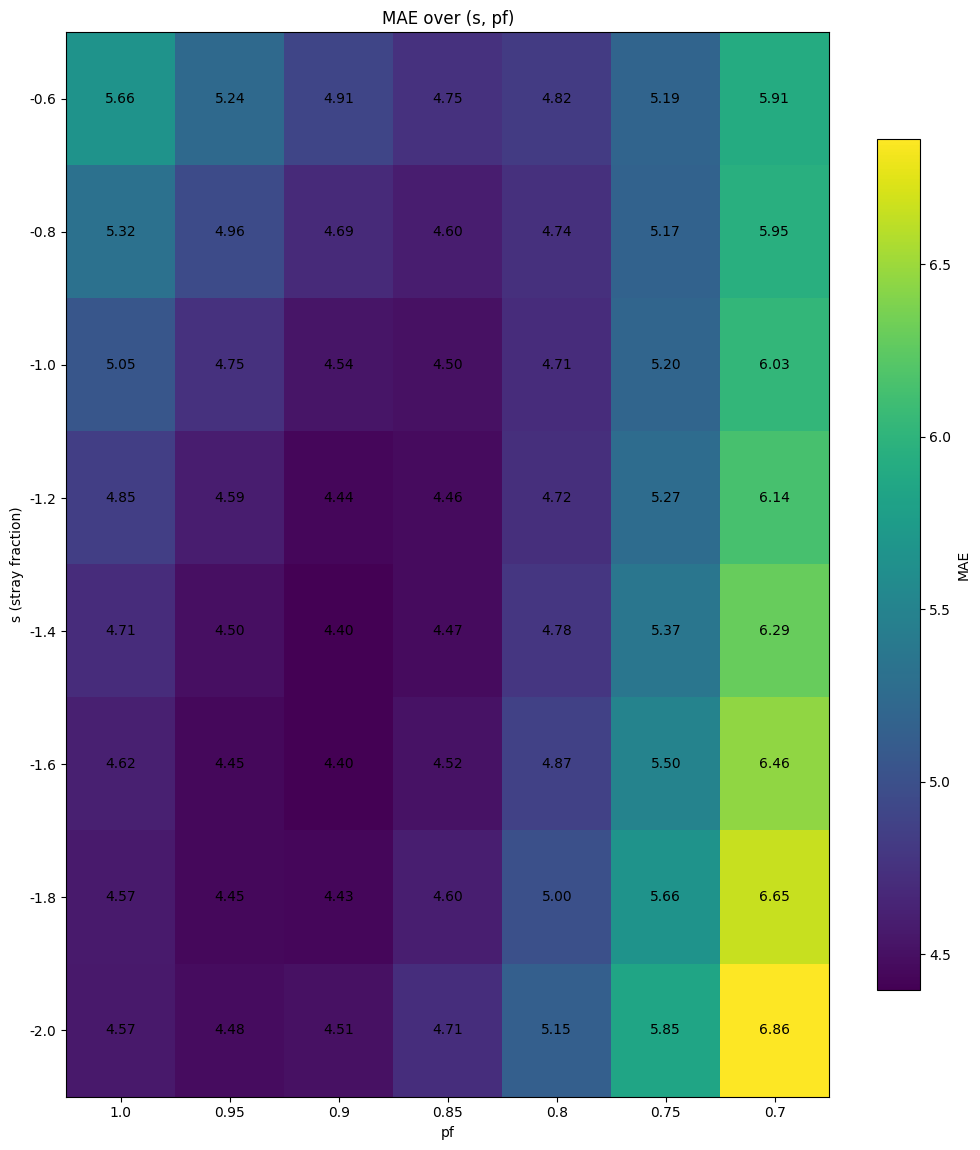

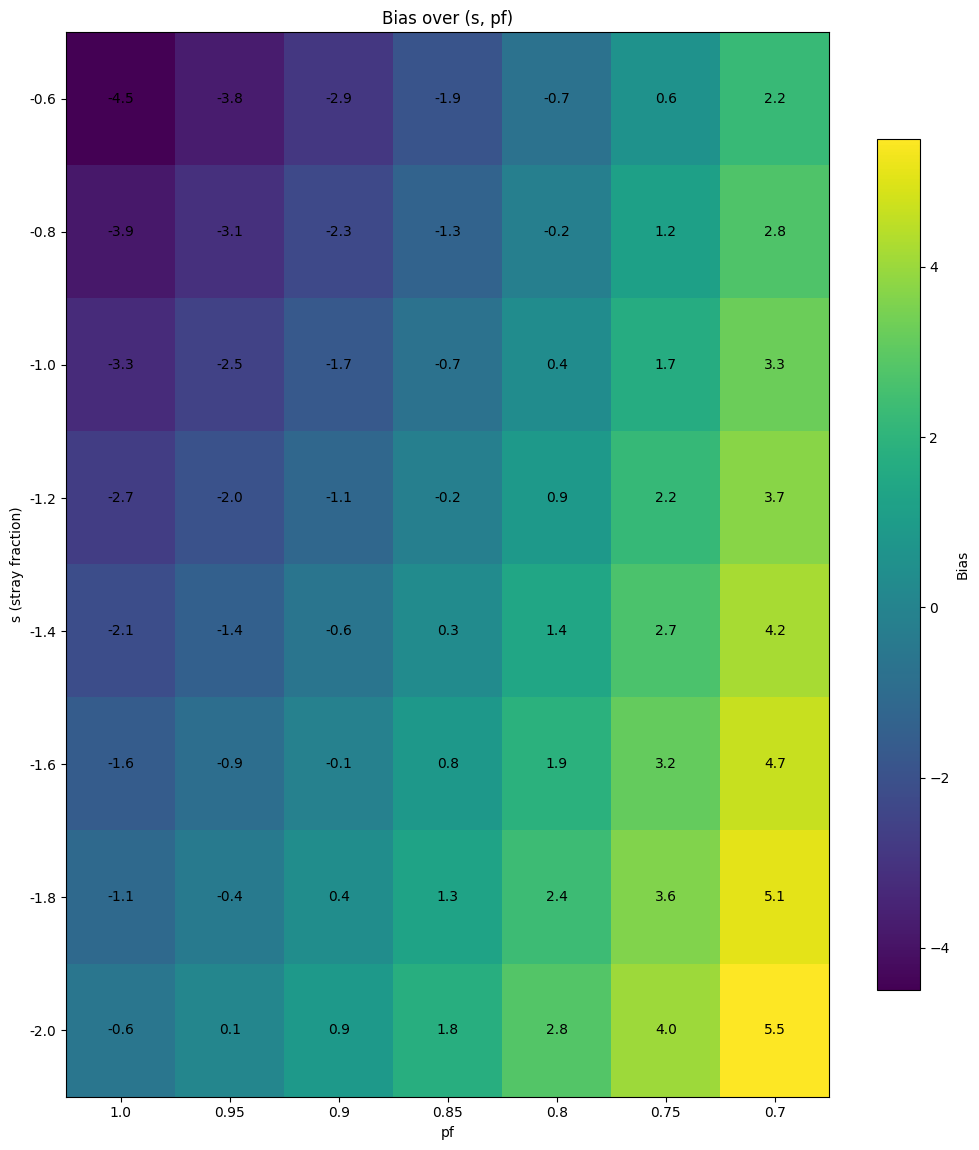

In [74]:
# ---- 1) Sweep all (s, pf) pairs and collect results ----
def run_grid(alldf, s_values, pf_values, save_path="wb_eval_grid.csv"):
    """
    For each (s, pf), calls:
       df_with_preds = wb_preds_for_df(alldf, s=s, pf=pf)
       eval_results  = eval_wb(df_with_preds)
    Returns a DataFrame with one row per (s, pf) containing top-level metrics.
    Also saves to CSV if save_path is not None.
    """
    rows = []
    for s, pf in product(s_values, pf_values):  # cartesian product
        dfp = wb_preds_for_df(alldf.copy(), s=s, pf=pf)  # use a copy just in case
        er  = eval_wb(dfp)

        # keep only top-level scalar metrics; stash the K-bin table as JSON (optional)
        byK = er.pop('by_K_bin', None)
        row = {'s': float(s), 'pf': float(pf)}
        row.update({k: (float(v) if np.isscalar(v) else v) for k, v in er.items()})
        if byK is not None:
            try:
                row['by_K_bin_json'] = json.dumps(byK.round(3).to_dict())
            except Exception:
                row['by_K_bin_json'] = None
        rows.append(row)

        print(f"s={s}, pf={pf} -> MAE={row['MAE']:.2f}, RMSE={row['RMSE']:.2f}, Bias={row['Bias']:.2f}, R2={row['R2']:.3f}")

    results = pd.DataFrame(rows)

    # normalize the column name for NRMSE if your eval returns 'NRMSE%_IQR'
    if 'NRMSE%_IQR' in results.columns:
        results = results.rename(columns={'NRMSE%_IQR': 'NRMSE_IQR_pct'})

    # optional: enforce the exact display order
    results['s']  = pd.Categorical(results['s'],  categories=s_values,  ordered=True)
    results['pf'] = pd.Categorical(results['pf'], categories=pf_values, ordered=True)

    if save_path:
        results.to_csv(save_path, index=False)
        print(f"\nSaved grid results to {save_path}")

    return results


# ---- 2) Plot a metric as an s×pf matrix (heatmap with value labels) ----
def plot_metric_grid(results_df, metric='RMSE', title=None, fmt="{:.2f}"):
    """
    Creates an s (rows) × pf (cols) matrix of the chosen metric and plots it.
    """
    if metric not in results_df.columns:
        raise KeyError(f"Metric '{metric}' not found in results_df columns: {list(results_df.columns)}")

    # ensure desired ordering (uses Categoricals if set above)
    df = results_df.copy()
    if not isinstance(df['s'].dtype, pd.CategoricalDtype):
        df = df.sort_values(['s', 'pf'])
    matrix = df.pivot(index='s', columns='pf', values=metric)

    fig, ax = plt.subplots(figsize=(1.2*matrix.shape[1]+2, 1.2*matrix.shape[0]+2))
    im = ax.imshow(matrix.values, aspect='auto')  # default colormap is fine

    # axes & labels
    ax.set_xticks(range(matrix.shape[1]), labels=[str(c) for c in matrix.columns])
    ax.set_yticks(range(matrix.shape[0]), labels=[str(r) for r in matrix.index])
    ax.set_xlabel("pf")
    ax.set_ylabel("s (stray fraction)")
    ax.set_title(title or f"{metric} over (s, pf)")

    # annotate cells
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix.values[i, j]
            if pd.notna(val):
                ax.text(j, i, fmt.format(val), ha='center', va='center')

    fig.colorbar(im, ax=ax, shrink=0.8, label=metric)
    plt.tight_layout()
    plt.show()


# ---- 3) Example usage ----
s_values = [-0.6, -0.8, -1, -1.2, -1.4, -1.6, -1.8, -2]
pf_values = [1, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
results_df = run_grid(alldf, s_values, pf_values, save_path="wb_full_eval_grid.csv")
plot_metric_grid(results_df, metric="RMSE")        # heatmap of RMSE
plot_metric_grid(results_df, metric="MAE")         # or MAE, Bias, R2, NRMSE_IQR_pct, etc.
plot_metric_grid(results_df, metric="Bias", fmt="{:.1f}")        # heatmap of Bias

**Best Results** (the values were computed using hotspot - oil and no h. Best results for this case, not in general)

s = -1.4

Pf = 0.85


This makes no sense, because *s* should be positive. Also, when using these values, even though global values look good, bin values show that the model underpredicts for lower loads and overpredicts for big loads. This probably highlights a wrong value of the variables empirically measured.

In [75]:
print("Best results (lowest RMSE):")
best_results = results_df.loc[results_df['MAE'].idxmin()]
print(best_results)
print(best_results['by_K_bin_json'])

Best results (lowest RMSE):
s                                                             -1.4
pf                                                             0.9
MAE                                                       4.395323
RMSE                                                      5.800598
Bias                                                     -0.608246
NRMSE_IQR_pct                                            37.690692
R2                                                        0.776287
P95_abs_err                                              11.659373
Max_abs_err                                             111.152118
by_K_bin_json    {"n": {"<0.5": 183419.0, "0.5\u20130.9": 23173...
Name: 30, dtype: object
{"n": {"<0.5": 183419.0, "0.5\u20130.9": 23173.0, "0.9\u20131.1": 407.0, ">1.1": 0.0}, "MAE": {"<0.5": 4.257, "0.5\u20130.9": 5.497, "0.9\u20131.1": 3.974, ">1.1": NaN}, "RMSE": {"<0.5": 5.588, "0.5\u20130.9": 7.277, "0.9\u20131.1": 5.089, ">1.1": NaN}, "Bias": {"<0.5": -0.69, 

## Model Fit to Each Transformer

There are two main reasons to get the parameters again:

- Tuning just *s* and *PF* made the model lose physical meaning ($s < 0$).
- There is no reason to assume that the transformer rating values remained constant throughout the years.

In [ ]:
keys = ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']
default_values = {
    's': 0.0,
    'pf': 1,
    'ambient_bias': 0.0,
}

# ---- WB model core (vectorized over a dataframe 'd') ----
def wb_predict(d, params):
    """
    d must have columns:
      ambient (°C), temp_meas (°C), P_kW (kW), rated_kVA (kVA),
      Pcu_ref_W (W at reference temp), P0_W (W at rated V)
    params: dict with keys ['s','pf','ambient_bias','deltaTopOil','deltaHotspot','x','y','h']
    Returns vector of predicted absolute HS temperature (°C).
    """
    s   = params['s']
    pf  = params['pf']
    amb = params['ambient_bias']
    dTO = params['heatRunTest_deltaTopOil']
    dH  = params['heatRunTest_deltaHotspot']
    x   = params['heatRunTest_x']
    y   = params['heatRunTest_y']
    h   = params['heatRunTest_h']

    # R and K
    Pload_ref = d['heatRunTest_copperLosses'] / (1.0 - s)  # W
    R = Pload_ref / d['heatRunTest_noLoadLosses']               # dimensionless
    K = (d['load'] / (pf * d['nominalLoad'] * 1000)) # per-unit (assumes P in kW, S_rated in MVA)

    # Clamp K to sane range to avoid exploding residuals during early iterations
    K = np.clip(K.values, 0, 2.5)

    # R may vary by timestamp if Pcu_ref_W or P0_W are columns; if they are scalars, broadcast works.
    R = np.asarray(R)

    top_oil_rise = dTO * np.power((1.0 + R * (K**2)) / (1.0 + R), x)
    hs_rise      = h * (K**y) * (dH - dTO)

    return d['temperature'].values + top_oil_rise + hs_rise #+ amb

# ---- residuals for robust least squares ----
def residuals_vec(theta, d, priors=None, prior_weight=0.0):
    # unpack vector -> params dict
    p = {
        's':            theta[0],
        'pf':           theta[1],
        'ambient_bias': theta[2],
        'heatRunTest_deltaTopOil':  theta[3],
        'heatRunTest_deltaHotspot': theta[4],
        'heatRunTest_x':            theta[5],
        'heatRunTest_y':            theta[6],
        'heatRunTest_h':            theta[7],
    }
    pred = wb_predict(d, p)
    res  = pred - d['hotspotTemperature'].values

    # optional light regularization toward priors to help identifiability (pf,s,x,y)
    if priors and prior_weight > 0:
        reg = []
        for k, mu in priors.items():
            reg.append(prior_weight * (p[k] - mu))
        res = np.concatenate([res, np.array(reg, dtype=float)])

    return res

# ---- get preds and metrics from model params ----
def get_preds_and_metrics(d, params_hat):

        # predictions & quick metrics
        pred = wb_predict(d, params_hat)
        err  = pred - d['hotspotTemperature'].values
        mae  = float(np.mean(np.abs(err)))
        rmse = float(np.sqrt(np.mean(err**2)))
        bias = float(np.mean(err))
        r2   = float(1 - np.sum(err**2) / np.sum((d['hotspotTemperature'] - d['hotspotTemperature'].mean())**2))
        return {'MAE': mae, 'RMSE': rmse, 'Bias': bias, 'R2': r2}, pred

# ---- fit one transformer (grouped df) ----
def fit_transformer(df_equipment,
                    init=None,
                    bounds=None,
                    priors=None,
                    prior_weight=0.0):
    # defaults
    if init is None:
        init = dict(
            s=0.10, pf=0.95, ambient_bias=0.0,
            heatRunTest_deltaTopOil=50.0, heatRunTest_deltaHotspot=63.0,  # rough starting rises (°C)
            heatRunTest_x=0.8, heatRunTest_y=1.5, heatRunTest_h=1.0
        )

    if bounds is None:
        bounds = dict(
            s=(0.0, 0.25),
            pf=(0.80, 1.00),
            ambient_bias=(-2.0, 2.0),
            heatRunTest_deltaTopOil=(5.0, 80.0),
            heatRunTest_deltaHotspot=(10.0, 120.0),
            heatRunTest_x=(0.6, 1.2),
            heatRunTest_y=(0.8, 2.2),
            heatRunTest_h=(0.7, 1.5),
        )

    # pack into vectors
    x0 = np.array([init[k] for k in ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']], dtype=float)
    lb = np.array([bounds[k][0] for k in ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']], dtype=float)
    ub = np.array([bounds[k][1] for k in ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']], dtype=float)

    # drop NAs and obviously bad rows
    d = df_equipment[['temperature','hotspotTemperature','load','nominalLoad','heatRunTest_copperLosses','heatRunTest_noLoadLosses']].dropna().copy()
    # optional: restrict to a time window here if needed

    # robust least squares
    sol = least_squares(
        residuals_vec, x0,
        args=(d, priors, prior_weight),
        bounds=(lb, ub),
        loss='soft_l1', f_scale=5.0,  # robust to outliers
        max_nfev=200
    )

    keys = ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']
    params_hat = {k: float(v) for k, v in zip(keys, sol.x)}
    metrics, pred = get_preds_and_metrics(d, params_hat)

    return params_hat, metrics, pred

# ---- batch fit across transformers ----
def fit_all_transformers(df,
                         id_col='equipmentId',
                         priors=None,
                         prior_weight=0.0, og_comparison=False):
    results = []
    preds   = []

    for eid, g in df.groupby(id_col):
        try:
            p_hat, metrics, pred = fit_transformer(g, priors=priors, prior_weight=prior_weight)
            row = {'equipmentId': eid, 'year': 2024, **p_hat, **metrics, 'n': int(len(g))}
            results.append(row)

            tmp = g[['dateTime', id_col, 'hotspotTemperature']].copy()
            tmp['wb_pred_fit'] = pred
            preds.append(tmp)
        except Exception as e:
            results.append({'equipmentId': eid, 'error': str(e)})

        if og_comparison:
            tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
            rename_map = {
                'deltaTopOil':     'heatRunTest_deltaTopOil',
                'deltaHotspot':    'heatRunTest_deltaHotspot',
                'x':               'heatRunTest_x',
                'y':               'heatRunTest_y',
                'h':               'heatRunTest_h',
                # Optional but useful elsewhere in your pipeline:
                'noLoadLosses':    'heatRunTest_noLoadLosses',
                'copperLosses':    'heatRunTest_copperLosses',
            }
            tfo_parameters.rename(columns=rename_map, inplace=True)
            if eid in tfo_parameters['equipmentId'].values:
                row = tfo_parameters[tfo_parameters['equipmentId'] == eid].iloc[0]
                og_params = {}
                for k in keys:
                    if k in row and pd.notna(row[k]):
                        og_params[k] = float(row[k])
                    elif k in default_values:
                        og_params[k] = default_values[k]
                    else:
                        raise KeyError(f"Missing parameter '{k}' for equipmentId={eid}")
                metrics, pred = get_preds_and_metrics(g, og_params)
                row = {'equipmentId': eid, 'year': g['manufactureYear'].values[0], **og_params, **metrics, 'n': int(len(g))}
                results.append(row)

    return pd.DataFrame(results), (pd.concat(preds, ignore_index=True) if preds else None)


In [128]:
# Your big dataframe needs these columns:
# timestamp, equipment_id, temp_meas (absolute HS temp), ambient (°C),
# P_kW (real power in kW), rated_kVA, Pcu_ref_W, P0_W

# Optional priors to stabilize fits (recommended)
# prior_weight = 0.2  # small pull toward priors

fit_table, pred_df = fit_all_transformers(alldf, id_col='equipmentId', og_comparison=True)

# Save results
fit_table.to_csv("wb_fit_parameters_by_transformer.csv", index=False)
if pred_df is not None:
    pred_df.to_csv("wb_predictions_fitted.csv", index=False)


In [ ]:
eid = 5025312
tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
RENAME_MAP = {
    'deltaTopOil':     'heatRunTest_deltaTopOil',
    'deltaHotspot':    'heatRunTest_deltaHotspot',
    'x':               'heatRunTest_x',
    'y':               'heatRunTest_y',
    'h':               'heatRunTest_h',
    # Optional but useful elsewhere in your pipeline:
    'noLoadLosses':    'heatRunTest_noLoadLosses',
    'copperLosses':    'heatRunTest_copperLosses',
}
tfo_parameters.rename(columns=RENAME_MAP, inplace=True)
# desired_cols = ['equipmentId'] + keys
# tfo_parameters = tfo_parameters[desired_cols]
if eid in tfo_parameters['equipmentId'].values:
    og_params = tfo_parameters[tfo_parameters['equipmentId'] == eid].iloc[0].to_dict()
    metrics, pred = get_preds_and_metrics(df, og_params)

In [129]:
fit_table

,equipmentId,year,s,pf,ambient_bias,heatRunTest_deltaTopOil,heatRunTest_deltaHotspot,heatRunTest_x,heatRunTest_y,heatRunTest_h,MAE,RMSE,Bias,R2,n
0,24917,2024,5.036357e-07,1.000000,1.980000,74.295733,57.782521,0.600000,1.668296,1.123231,3.697070,4.726596,-0.126970,0.383362,14664
1,24917,1997,0.000000e+00,1.000000,0.000000,54.800000,72.000000,0.730000,1.400000,1.300000,4.737509,5.781923,-1.573298,0.077263,14664
2,33291,2024,3.771260e-09,1.000000,1.980000,79.999999,53.869058,0.637083,1.736099,1.186269,2.228510,2.788943,-0.045905,0.713541,14664
3,33291,1998,0.000000e+00,1.000000,0.000000,47.900000,65.400000,0.740000,1.430000,1.300000,6.079759,6.772061,-6.000365,-0.688981,14664
4,5004597,2024,9.975030e-02,0.921184,1.980000,60.539622,35.975918,0.600000,2.160808,1.264024,2.447127,3.688879,-0.326771,0.636929,14664
5,5004597,2001,0.000000e+00,1.000000,0.000000,48.900000,65.700000,0.620000,1.980000,1.300000,2.870896,4.253589,-1.876394,0.517259,14664
6,5004625,2024,2.500000e-01,0.800000,1.980000,65.850804,27.450293,0.600001,2.183562,1.463129,2.597965,3.904975,-0.246219,0.629797,14664
7,5004625,2001,0.000000e+00,1.000000,0.000000,48.900000,65.700000,0.620000,1.980000,1.300000,3.081849,4.448063,-1.927942,0.519663,14664
8,5017843,2024,6.460667e-07,1.000000,-1.980000,61.933554,64.264145,0.708594,0.800000,1.025598,1.710261,2.192043,-0.024277,0.873137,14664
9,5017843,2005,0.000000e+00,1.000000,0.000000,45.400000,60.800000,0.900000,1.600000,1.350000,5.351348,5.765622,-5.330528,0.122334,14664


In [64]:
def compute_differences(df):
    # sort to make sure earlier year comes first
    df_sorted = df.sort_values(['equipmentId','year'])
    
    diffs = []
    for eid, g in df_sorted.groupby('equipmentId'):
        if len(g) != 2:
            raise ValueError(f"Equipment {eid} does not have exactly 2 rows")
        
        # earlier and later rows
        g = g.reset_index(drop=True)
        row0 = g.iloc[0]
        row1 = g.iloc[1]
        
        diff = (row1 - row0).to_dict()  # subtract elementwise
        diff['equipmentId'] = eid
        diff['year_diff'] = row1['year'] - row0['year']
        
        diffs.append(diff)
    
    return pd.DataFrame(diffs)

# Example usage:
# diff_df = compute_differences(fit_table)
# diff_df

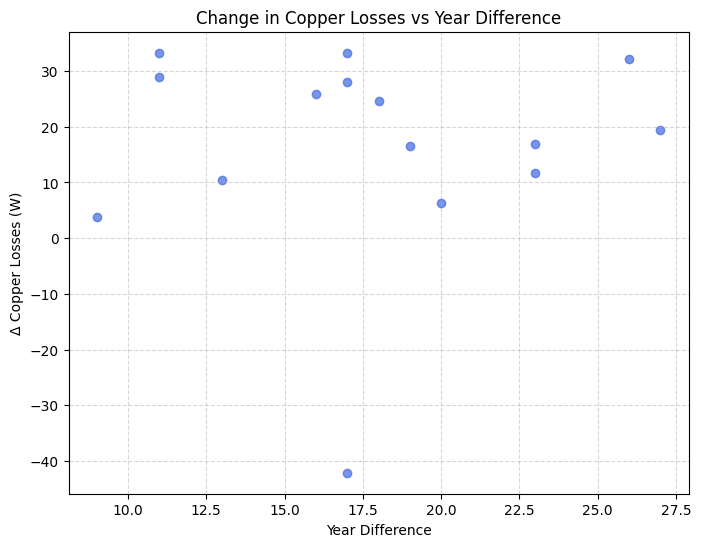

In [132]:
plt.figure(figsize=(8,6))
plt.scatter(diff_df['year_diff'], diff_df['heatRunTest_deltaTopOil'], color='royalblue', alpha=0.7)

plt.xlabel("Year Difference")
plt.ylabel("Δ Copper Losses (W)")
plt.title("Change in Copper Losses vs Year Difference")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

This code accepts different parameters as input and only computes least squares on those.

In [ ]:
# ---- master registry for all parameters you might fit ----
PARAMS_REGISTRY = {
    # thermal shape/scale params
    's':                          {'default': 0.0, 'bounds': (0.0, 0.25)},
    'pf':                         {'default': 1, 'bounds': (0.80, 1.00)},
    'ambient_bias':               {'default': 0.0,  'bounds': (-2.0, 2.0)},

    'heatRunTest_deltaTopOil':    {'default': 50.0, 'bounds': (5.0, 80.0)},
    'heatRunTest_deltaHotspot':   {'default': 63.0, 'bounds': (10.0, 120.0)},
    'heatRunTest_x':              {'default': 0.8,  'bounds': (0.6, 1.2)},
    'heatRunTest_y':              {'default': 1.5,  'bounds': (0.8, 2.2)},
    'heatRunTest_h':              {'default': 1.0,  'bounds': (0.7, 1.5)},

    # equipment constants (OPTIONALLY fit as scalars overriding df columns)
    'heatRunTest_copperLosses':   {'default': None, 'bounds': (10.0, 1e6)},  # W
    'heatRunTest_noLoadLosses':   {'default': None, 'bounds': (10.0, 1e6)},  # W
    'nominalLoad':                {'default': None, 'bounds': (1.0, 1e6)},   # kVA
}

RENAME_MAP = {
    'deltaTopOil':     'heatRunTest_deltaTopOil',
    'deltaHotspot':    'heatRunTest_deltaHotspot',
    'x':               'heatRunTest_x',
    'y':               'heatRunTest_y',
    'h':               'heatRunTest_h',
    # Optional but useful elsewhere in your pipeline:
    'noLoadLosses':    'heatRunTest_noLoadLosses',
    'copperLosses':    'heatRunTest_copperLosses',
}

In [ ]:
def build_x0_bounds(selected_keys, init_overrides=None, bounds_overrides=None):
    x0, lb, ub = [], [], []
    for k in selected_keys:
        dflt  = PARAMS_REGISTRY[k]['default']
        b_l, b_u = PARAMS_REGISTRY[k]['bounds']
        if init_overrides and k in init_overrides:
            dflt = init_overrides[k]
        if bounds_overrides and k in bounds_overrides:
            b_l, b_u = bounds_overrides[k]
        if dflt is None:
            # if no default, try infer from df later; for now seed mid of bounds
            dflt = (b_l + b_u) / 2.0
        x0.append(float(dflt)); lb.append(float(b_l)); ub.append(float(b_u))
    return np.array(x0), np.array(lb), np.array(ub)

def vec_to_params(theta, selected_keys):
    return {k: float(v) for k, v in zip(selected_keys, theta)}

def _get_series_or_param(d, params, param_key, df_col):
    """If param_key was selected & fitted, use that scalar (broadcast).
       Else fallback to the dataframe column."""
    if param_key in params:
        return np.full(len(d), float(params[param_key]), dtype=float)
    return d[df_col].to_numpy(dtype=float)

def wb_predict(d, params):
    s   = params.get('s',  PARAMS_REGISTRY['s']['default'])
    pf  = params.get('pf', PARAMS_REGISTRY['pf']['default'])

    dTO = params.get('heatRunTest_deltaTopOil',  PARAMS_REGISTRY['heatRunTest_deltaTopOil']['default'])
    dH  = params.get('heatRunTest_deltaHotspot', PARAMS_REGISTRY['heatRunTest_deltaHotspot']['default'])
    x   = params.get('heatRunTest_x',            PARAMS_REGISTRY['heatRunTest_x']['default'])
    y   = params.get('heatRunTest_y',            PARAMS_REGISTRY['heatRunTest_y']['default'])
    h   = params.get('heatRunTest_h',            PARAMS_REGISTRY['heatRunTest_h']['default'])

    # equipment scalars (may be fitted or from df)
    Pcu_ref_W = _get_series_or_param(d, params, 'heatRunTest_copperLosses', 'heatRunTest_copperLosses')
    P0_W      = _get_series_or_param(d, params, 'heatRunTest_noLoadLosses', 'heatRunTest_noLoadLosses')
    S_kVA     = _get_series_or_param(d, params, 'nominalLoad',              'nominalLoad')

    # R and K
    Pload_ref = Pcu_ref_W / (1.0 - s)
    R = Pload_ref / P0_W

    # If you have 'load' in kW:
    P_kW = d['load'].to_numpy(dtype=float)
    K = P_kW / (pf * S_kVA * 1000)  # per-unit (assuming nameplate in kVA)
    K = np.clip(K, 0.0, 2.5)

    # rises
    top_oil_rise = dTO * np.power((1.0 + R * (K**2)) / (1.0 + R), x)
    hs_rise      = h * (K**y) * (dH - dTO)

    ambient = d['temperature'].to_numpy(dtype=float)
    amb_bias = params.get('ambient_bias', 0.0)
    return ambient + top_oil_rise + hs_rise + amb_bias

def residuals_vec(theta, d, selected_keys, priors=None, prior_weight=0.0):
    params = vec_to_params(theta, selected_keys)
    pred = wb_predict(d, params)
    res  = pred - d['hotspotTemperature'].to_numpy(dtype=float)

    if priors and prior_weight > 0:
        reg = []
        for k, mu in priors.items():
            if k in params:
                reg.append(prior_weight * (params[k] - mu))
        if reg:
            res = np.concatenate([res, np.array(reg, dtype=float)], axis=0)
    return res

def get_preds_and_metrics(d, params_hat):
    pred = wb_predict(d, params_hat)
    tgt  = d['hotspotTemperature'].to_numpy(dtype=float)
    err  = pred - tgt
    mae  = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    bias = float(np.mean(err))
    denom = np.sum((tgt - tgt.mean())**2)
    r2   = float(1 - np.sum(err**2) / denom) if denom > 0 else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'Bias': bias, 'R2': r2}, pred

def fit_transformer(df_equipment,
                    selected_keys,
                    init_overrides=None,
                    bounds_overrides=None,
                    priors=None,
                    prior_weight=0.0):

    # core columns we always need in df (even if some are fitted, we still allow fallback)
    needed = ['temperature','hotspotTemperature','load','nominalLoad',
              'heatRunTest_copperLosses','heatRunTest_noLoadLosses']
    have = [c for c in needed if c in df_equipment.columns]
    if len(have) < len(needed):
        missing = [c for c in needed if c not in df_equipment.columns]
        raise KeyError(f"Missing columns: {missing}")

    d = df_equipment[needed].dropna().copy()
    if d.empty:
        raise ValueError("No valid rows after dropna for this transformer.")

    x0, lb, ub = build_x0_bounds(selected_keys, init_overrides, bounds_overrides)

    sol = least_squares(
        residuals_vec, x0,
        args=(d, selected_keys, priors, prior_weight),
        bounds=(lb, ub),
        loss='soft_l1', f_scale=5.0, max_nfev=500
    )
    params_hat = vec_to_params(sol.x, selected_keys)
    metrics, pred = get_preds_and_metrics(d, params_hat)
    return params_hat, metrics, pred

def fit_all_transformers(df, id_col='equipmentId', selected_keys=None,
                         init_overrides=None, bounds_overrides=None,
                         priors=None, prior_weight=0.0, og_comparison=False,
                         savefile = None, print_metrics = False):
    if selected_keys is None:
        selected_keys = ['s','pf','ambient_bias','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']

    results, preds = [], []
    for eid, g in df.groupby(id_col):
        try:
            p_hat, metrics, pred = fit_transformer(
                g, selected_keys,
                init_overrides=init_overrides,
                bounds_overrides=bounds_overrides,
                priors=priors, prior_weight=prior_weight
            )
            row = {'equipmentId': eid, 'year': 2024, **p_hat, **metrics, 'n': int(len(g))}
            results.append(row)

            tmp = g[['dateTime', id_col, 'hotspotTemperature']].copy()
            tmp['wb_pred_fit'] = pred
            preds.append(tmp)
        except Exception as e:
            results.append({'equipmentId': eid, 'error': str(e)})

        if og_comparison:
            tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
            tfo_parameters.rename(columns=RENAME_MAP, inplace=True)
            if eid in tfo_parameters['equipmentId'].values:
                row = tfo_parameters[tfo_parameters['equipmentId'] == eid].iloc[0]
                og_params = {}
                for k in selected_keys:
                    if k in row and pd.notna(row[k]):
                        og_params[k] = float(row[k])
                    elif k in default_values:
                        og_params[k] = default_values[k]
                    else:
                        raise KeyError(f"Missing parameter '{k}' for equipmentId={eid}")
                metrics, pred = get_preds_and_metrics(g, og_params)
                row = {'equipmentId': eid, 'year': g['manufactureYear'].values[0], **og_params, **metrics, 'n': int(len(g))}
                results.append(row)

    res_df = pd.DataFrame(results)
    pred_df = pd.concat(preds, ignore_index=True) if preds else None

    if savefile is not None:
        fit_table.to_csv(f"wb_{savefile}_parameters.csv", index=False)
        if pred_df is not None:
            pred_df.to_csv(f"wb_{savefile}_fitted.csv", index=False)

    if print_metrics:
        avg_metrics = fit_table[['MAE', 'RMSE', 'Bias', 'R2', 'n']]
        avg_metrics = avg_metrics[fit_table['year'] == 2024]
        avg_metrics = avg_metrics.mean()
        print(avg_metrics)

    return res_df, pred_df



In [46]:
selected_keys = [
    'ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    # 'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    print_metrics= True
)


selected_keys = [
    # 's','pf','ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    # 'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    og_comparison=False,
    savefile = "fit2",
    print_metrics = True
)


MAE         3.221384
RMSE        4.267502
Bias       -0.394534
R2          0.521118
n       14664.000000
dtype: float64
MAE         3.161425
RMSE        4.193415
Bias       -0.228378
R2          0.538036
n       14664.000000
dtype: float64


In [47]:
selected_keys = [
    's','pf','ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    # 'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    print_metrics=True
)

selected_keys = [
    's','pf',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    # 'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    print_metrics=True
)


MAE         3.221384
RMSE        4.267502
Bias       -0.394534
R2          0.521118
n       14664.000000
dtype: float64
MAE         3.159705
RMSE        4.193826
Bias       -0.242201
R2          0.537965
n       14664.000000
dtype: float64


In [48]:
selected_keys = [
    's','pf','ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    print_metrics= True
)

selected_keys = [
    's','pf',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    print_metrics= True
)

MAE         3.207922
RMSE        4.252546
Bias       -0.342269
R2          0.524427
n       14664.000000
dtype: float64
MAE         3.169917
RMSE        4.229942
Bias       -0.135420
R2          0.533415
n       14664.000000
dtype: float64


This looks like nonsense when compared to the experimental results

| Parameter                                | Physical meaning                            | Possible time-dependent effect                                          | Likely trend with age          |
| ---------------------------------------- | ------------------------------------------- | ----------------------------------------------------------------------- | ------------------------------ |
| **s** (stray-loss fraction)              | Fraction of load losses in structural parts | Winding displacement, mechanical loosening → altered leakage flux paths | ↑ (slight increase)            |
| **pf** (effective load power factor)     | Typical operating load PF                   | Customer mix changes (industrial → residential, renewables, EVs)        | Variable (↑ or ↓)              |
| **ambient\_bias**                        | Sensor/systematic offset                    | Sensor drift, probe replacement, fouling causing localized heating      | Unpredictable (±), often drift |
| **ΔTopOil (heatRunTest\_deltaTopOil)**   | Oil rise at rated load                      | Oil oxidation, sludge formation, fan/pump wear                          | ↑ (higher rises)               |
| **ΔHotspot (heatRunTest\_deltaHotspot)** | Hotspot rise at rated load                  | Insulation embrittlement, reduced heat transfer to oil                  | ↑ (higher rises)               |
| **x** (oil exponent)                     | Nonlinearity of oil heating curve           | Oil viscosity increase, convection impairment                           | ↑ (slightly higher)            |
| **y** (winding exponent)                 | Nonlinearity of winding heating curve       | Blocked ducts, uneven cooling, sludge                                   | ↑ (slightly higher)            |
| **h** (hotspot factor)                   | Ratio hotspot/top-oil                       | Localized hot-spots worsen as insulation/cooling paths degrade          | ↑                              |
| **Copper losses (Pcu\_ref\_W)**          | I²R losses in windings                      | Conductor oxidation, joints resistance increase, deformation            | ↑                              |
| **No-load losses (P0\_W)**               | Core losses at rated voltage                | Lamination insulation breakdown → higher eddy currents                  | ↑ (rare, but serious)          |
| **Nominal load (S\_rated)**              | Rated kVA capacity                          | Effective derating in practice due to aging cooling/insulation          | ↓ (derated capacity)           |


## What's next

1. Do this same analysis with just one variable at a time and try to find correlation to years in use
2. Distinguish between global (one analysis fits all transformers) and individual
    - Maybe individual makes more sense. i could check whether parameter fit on a nearby timeframe translates into accuracy in other timeframes (e.g. fitting parameters for a whole year since the start of the data and then checking on the remaining data how good performance is)
3. Now that it is clear that this variables have changed over time, then find which ones contribute the most to the final performance (choose rmse or mae, prob the one that is the least sensible to outliers given the data is not perfect and having outliers doesnt necessarily mean the model is wrong)
4. Read about limitations of the least_squares function
5. IDEA: Given that now I am extending on the model, then maybe I could add a term like *g · T_pred(t-1)* so last predicted temperature. This way we could add some temporal dynamic to the model, as the past temperature would have some effect on the T prediction. We could even go as far as to add a cooling term to make temporal gradients in T follow difussion formulas. this would make the model heavy, but pinns are good at dealing with this, and AD would assist with the computation during training.
6. I also need to decide on the potential training protocol
    - Fixed window of 10 days or smth?
    - Full year window? too heavy imo
    - One day window?
    - The thing is given that the load contains very similar fft harmonics as the hotspot temperature, and the load is one of the input variables, then probably the window length is not that important and we could literally predict step by step.
7. Idea for benchmarking. Comparing how good this model is at predicting the T vs how good models are at predicting future load, because in a real usecase the model would be used with the predicted load. Dataset for load prediction available at elia open data.

### Variables
(First draft)

**Input**
- Load(t)
- T_ambient(t)
- T_pred(t-1)

**Output**
- T_pred(t)

During training I should probably use T_gt(t-1) instead of T_pred during a number of epochs

### 1. Do this same analysis with just one variable at a time and try to find correlation to years in use

#### Fixing init_override

In [ ]:
keys = selected_keys = [
    's','pf','ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    # 'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

for key in keys:
    selected_keys = [
        key
    ]
    init_overrides = tfo_parameters.set_index('equipmentId').to_dict(orient='index')
    fit_table, pred_df = fit_all_transformers(
        alldf, id_col='equipmentId',
        selected_keys=selected_keys,
        print_metrics= True
    )

In [2]:
# Build per-equipment defaults (used for both init seeds and non-fitted params)
def load_base_params_by_eid(TFO_PARAMETERS_FILE):
    tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)

    # Normalize names to match model keys
    rename_map = {
        'deltaTopOil':     'heatRunTest_deltaTopOil',
        'deltaHotspot':    'heatRunTest_deltaHotspot',
        'x':               'heatRunTest_x',
        'y':               'heatRunTest_y',
        'h':               'heatRunTest_h',
        'noLoadLosses':    'heatRunTest_noLoadLosses',
        'copperLosses':    'heatRunTest_copperLosses',
        # optional in file:
        'pf':              'pf',
        's':               's',
        'ambient_bias':    'ambient_bias',
        'ambiantTemperature': 'ambient_bias',  # if you had this typo
        'nominalLoad':     'nominalLoad',
    }
    tfo_parameters = tfo_parameters.rename(columns=rename_map)

    # Keys we care about as scalar parameters
    all_param_keys = [
        's','pf','ambient_bias',
        'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot',
        'heatRunTest_x','heatRunTest_y','heatRunTest_h',
        'heatRunTest_copperLosses','heatRunTest_noLoadLosses',
        'nominalLoad'
    ]

    base_params_by_eid = {}
    for _, r in tfo_parameters.iterrows():
        eid = r['equipmentId']
        d = {}
        for k in all_param_keys:
            if k in r and pd.notna(r[k]):
                try:
                    d[k] = float(r[k])
                except Exception:
                    pass
        base_params_by_eid[eid] = d
    return base_params_by_eid


In [ ]:
# Registry stays as your source-of-last-resort (only if base params missing)
PARAMS_REGISTRY = {
    's':                        {'default': 0.0, 'bounds': (0.0, 0.25)},
    'pf':                       {'default': 1, 'bounds': (0.80, 1.00)},
    'ambient_bias':             {'default': 0.0,  'bounds': (-2.0, 2.0)},
    'heatRunTest_deltaTopOil':  {'default': 50.0, 'bounds': (5.0, 80.0)},
    'heatRunTest_deltaHotspot': {'default': 63.0, 'bounds': (10.0, 120.0)},
    'heatRunTest_x':            {'default': 0.8,  'bounds': (0.6, 1.2)},
    'heatRunTest_y':            {'default': 1.5,  'bounds': (0.8, 2.2)},
    'heatRunTest_h':            {'default': 1.0,  'bounds': (0.7, 1.5)},
    'heatRunTest_copperLosses': {'default': None, 'bounds': (10.0, 1e6)},
    'heatRunTest_noLoadLosses': {'default': None, 'bounds': (10.0, 1e6)},
    'nominalLoad':              {'default': None, 'bounds': (1.0, 1e6)},
}

def build_x0_bounds(selected_keys, base_params=None, init_overrides=None, bounds_overrides=None):
    """
    x0 seeds priority:
      1) init_overrides[k] (explicit seed for this eid)
      2) base_params[k]    (per-transformer defaults from tfo_parameters)
      3) PARAMS_REGISTRY default (or midpoint if None)
    """
    x0, lb, ub = [], [], []
    for k in selected_keys:
        # bounds
        b_l, b_u = PARAMS_REGISTRY[k]['bounds']
        if bounds_overrides and k in bounds_overrides:
            b_l, b_u = bounds_overrides[k]

        # default / seed
        if init_overrides and k in init_overrides:
            val = init_overrides[k]
        elif base_params and k in base_params:
            val = base_params[k]
        else:
            val = PARAMS_REGISTRY[k]['default']
            if val is None:  # no sensible default -> midpoint of bounds
                val = (b_l + b_u) / 2.0

        x0.append(float(val)); lb.append(float(b_l)); ub.append(float(b_u))
    return np.array(x0), np.array(lb), np.array(ub)

def _get_series_or_param(d, params, param_key, df_col):
    """If param_key provided in params, broadcast that scalar; else use df column."""
    if param_key in params:
        return np.full(len(d), float(params[param_key]), dtype=float)
    return d[df_col].to_numpy(dtype=float)

def wb_predict(d, params):
    # Note: we DO NOT add ambient_bias in prediction per your latest setup
    s   = params.get('s',  PARAMS_REGISTRY['s']['default'])
    pf  = params.get('pf', PARAMS_REGISTRY['pf']['default'])

    dTO = params.get('heatRunTest_deltaTopOil',  PARAMS_REGISTRY['heatRunTest_deltaTopOil']['default'])
    dH  = params.get('heatRunTest_deltaHotspot', PARAMS_REGISTRY['heatRunTest_deltaHotspot']['default'])
    x   = params.get('heatRunTest_x',            PARAMS_REGISTRY['heatRunTest_x']['default'])
    y   = params.get('heatRunTest_y',            PARAMS_REGISTRY['heatRunTest_y']['default'])
    h   = params.get('heatRunTest_h',            PARAMS_REGISTRY['heatRunTest_h']['default'])
    amb_bias = params.get('ambient_bias',        PARAMS_REGISTRY['ambient_bias']['default'])

    # May come from params (tfo defaults or fitted) or from df
    Pcu_ref_W = _get_series_or_param(d, params, 'heatRunTest_copperLosses', 'heatRunTest_copperLosses')
    P0_W      = _get_series_or_param(d, params, 'heatRunTest_noLoadLosses', 'heatRunTest_noLoadLosses')
    S_namepl  = _get_series_or_param(d, params, 'nominalLoad',              'nominalLoad')

    # R and K (keep EXACT old K behavior: nominalLoad interpreted as MVA -> *1000 to kVA)
    Pload_ref = Pcu_ref_W / (1.0 - s)
    R = Pload_ref / P0_W

    P_kW = d['load'].to_numpy(dtype=float)
    S_base = S_namepl * 1000.0  # MVA -> kVA (matches your old model)
    K = P_kW / (pf * S_base)
    K = np.clip(K, 0.0, 2.5)

    top_oil_rise = dTO * np.power((1.0 + R * (K**2)) / (1.0 + R), x)
    hs_rise      = h * (K**y) * (dH - dTO)

    ambient = d['temperature'].to_numpy(dtype=float)
    return ambient + top_oil_rise + hs_rise + amb_bias

def fit_transformer(df_equipment,
                    selected_keys,
                    base_params=None,           # NEW
                    init_overrides=None,
                    bounds_overrides=None,
                    priors=None,
                    prior_weight=0.0):

    needed = ['temperature','hotspotTemperature','load','nominalLoad',
              'heatRunTest_copperLosses','heatRunTest_noLoadLosses']
    d = df_equipment[needed].dropna().copy()
    if d.empty:
        raise ValueError("No valid rows after dropna for this transformer.")

    x0, lb, ub = build_x0_bounds(
        selected_keys,
        base_params=base_params,      # seeds from tfo_parameters if present
        init_overrides=init_overrides,
        bounds_overrides=bounds_overrides
    )

    sol = least_squares(
        residuals_vec, x0,
        args=(d, selected_keys, base_params, priors, prior_weight),
        bounds=(lb, ub),
        loss='soft_l1', f_scale=5.0, max_nfev=500
    )
    params_hat = {k: float(v) for k, v in zip(selected_keys, sol.x)}
    metrics, pred = get_preds_and_metrics(d, params_hat, base_params=base_params)
    return params_hat, metrics, pred


def residuals_vec(theta, d, selected_keys, base_params=None, priors=None, prior_weight=0.0):
    fitted = {k: float(v) for k, v in zip(selected_keys, theta)}
    # Per-eid defaults for NON-fitted params:
    merged = {**(base_params or {}), **fitted}
    pred = wb_predict(d, merged)
    res  = pred - d['hotspotTemperature'].to_numpy(dtype=float)

    if priors and prior_weight > 0:
        reg = []
        for k, mu in priors.items():
            if k in fitted:  # regularize only the free params
                reg.append(prior_weight * (fitted[k] - mu))
        if reg:
            res = np.concatenate([res, np.array(reg, dtype=float)])
    return res

def get_preds_and_metrics(d, params_hat, base_params=None):
    merged = {**(base_params or {}), **params_hat}
    pred = wb_predict(d, merged)
    tgt  = d['hotspotTemperature'].to_numpy(dtype=float)
    err  = pred - tgt
    mae  = float(np.mean(np.abs(err)))
    rmse = float(np.sqrt(np.mean(err**2)))
    bias = float(np.mean(err))
    denom = np.sum((tgt - tgt.mean())**2)
    r2   = float(1 - np.sum(err**2) / denom) if denom > 0 else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'Bias': bias, 'R2': r2}, pred

def fit_transformer(df_equipment,
                    selected_keys,
                    base_params=None,           # NEW
                    init_overrides=None,
                    bounds_overrides=None,
                    priors=None,
                    prior_weight=0.0):

    needed = ['temperature','hotspotTemperature','load','nominalLoad',
              'heatRunTest_copperLosses','heatRunTest_noLoadLosses']
    d = df_equipment[needed].dropna().copy()
    if d.empty:
        raise ValueError("No valid rows after dropna for this transformer.")

    x0, lb, ub = build_x0_bounds(
        selected_keys,
        base_params=base_params,      # seeds from tfo_parameters if present
        init_overrides=init_overrides,
        bounds_overrides=bounds_overrides
    )

    sol = least_squares(
        residuals_vec, x0,
        args=(d, selected_keys, base_params, priors, prior_weight),
        bounds=(lb, ub),
        loss='soft_l1', f_scale=5.0, max_nfev=500
    )
    params_hat = {k: float(v) for k, v in zip(selected_keys, sol.x)}
    metrics, pred = get_preds_and_metrics(d, params_hat, base_params=base_params)
    return params_hat, metrics, pred

def fit_all_transformers(df, id_col='equipmentId', selected_keys=None,
                         base_params_by_eid=None,   # NEW
                         init_overrides_by_eid=None,
                         bounds_overrides=None,
                         priors=None, prior_weight=0.0,
                         savefile = None, print_metrics = False,
                         og_comparison = False):
    if selected_keys is None:
        selected_keys = ['s','pf','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']

    results, preds = [], []
    for eid, g in df.groupby(id_col):
        try:
            base_params = (base_params_by_eid or {}).get(eid, {})
            init_over   = (init_overrides_by_eid or {}).get(eid, None)

            p_hat, metrics, pred = fit_transformer(
                g, selected_keys,
                base_params=base_params,      # <<— per-transformer defaults
                init_overrides=init_over,     # <<— optional per-transformer seeds
                bounds_overrides=bounds_overrides,
                priors=priors, prior_weight=prior_weight
            )
            row = {'equipmentId': eid, 'year': 2024, **({**base_params, **p_hat}), **metrics, 'n': int(len(g))}
            results.append(row)

            tmp = g[['dateTime', id_col, 'hotspotTemperature']].copy()
            tmp['wb_pred_fit'] = pred
            preds.append(tmp)

        except Exception as e:
            results.append({'equipmentId': eid, 'error': str(e)})

        if og_comparison:
            tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
            tfo_parameters.rename(columns=RENAME_MAP, inplace=True)
            if eid in tfo_parameters['equipmentId'].values:
                row = tfo_parameters[tfo_parameters['equipmentId'] == eid].iloc[0]
                og_params = {}
                for k in selected_keys:
                    if k in row and pd.notna(row[k]):
                        og_params[k] = float(row[k])
                    elif k in default_values:
                        og_params[k] = default_values[k]
                    else:
                        raise KeyError(f"Missing parameter '{k}' for equipmentId={eid}")
                metrics, pred = get_preds_and_metrics(g, og_params)
                row = {'equipmentId': eid, 'year': g['manufactureYear'].values[0], **og_params, **metrics, 'n': int(len(g))}
                results.append(row)

    res_df = pd.DataFrame(results)
    pred_df = pd.concat(preds, ignore_index=True) if preds else None

    if savefile is not None:
        res_df.to_csv(f"wb_{savefile}_parameters.csv", index=False)
        if pred_df is not None:
            pred_df.to_csv(f"wb_{savefile}_fitted.csv", index=False)

    if print_metrics:
        avg_metrics = res_df[['MAE', 'RMSE', 'Bias', 'R2', 'n']]
        avg_metrics = avg_metrics[res_df['year'] == 2024]
        avg_metrics = avg_metrics.mean()
        print(avg_metrics)

    return res_df, pred_df


In [ ]:
# 1) Build per-equipment defaults from TFO_PARAMETERS_FILE
base_params_by_eid = load_base_params_by_eid(TFO_PARAMETERS_FILE)

# 2) Choose what you want to fit
selected_keys = ['s','pf','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h']
# (ambient_bias not used in prediction per your comment)

# 3) (Optional) per-equipment init seeds different from defaults
init_overrides_by_eid = {}  # or build similarly if you want to override specific seeds

# 4) Fit
fit_table, pred_df = fit_all_transformers(
    alldf, id_col='equipmentId',
    selected_keys=selected_keys,
    base_params_by_eid=base_params_by_eid,      # <<— key line
    init_overrides_by_eid=init_overrides_by_eid,
    prior_weight=0.1
)


In [ ]:
keys = selected_keys = [
    's','pf','ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

base_params_by_eid = load_base_params_by_eid(TFO_PARAMETERS_FILE)

all_tables = pd.DataFrame()
for key in keys:
    selected_keys = [
        key
    ]
    # init_overrides = tfo_parameters.set_index('equipmentId').to_dict(orient='index')
    fit_table, pred_df = fit_all_transformers(
        alldf, id_col='equipmentId',
        selected_keys=selected_keys,
        # base_params_by_eid=base_params_by_eid,      # <<— key line
        # init_overrides_by_eid=init_overrides_by_eid,
        prior_weight=0.1,
        print_metrics= True
    )
    all_tables = pd.concat([all_tables, fit_table])
    # break

all_tables

MAE         8.893724
RMSE        9.834580
Bias       -8.729170
R2         -1.700576
n       14664.000000
dtype: float64


,equipmentId,year,s,pf,ambient_bias,heatRunTest_deltaTopOil,heatRunTest_deltaHotspot,heatRunTest_x,heatRunTest_y,heatRunTest_h,heatRunTest_copperLosses,heatRunTest_noLoadLosses,nominalLoad,MAE,RMSE,Bias,R2,n
0,24917,2024,3.754221e-25,0.95,0.0,50.0,63.0,0.8,1.5,1.0,None,None,None,6.963774,8.230597,-6.486156,-0.869804,14664
1,33291,2024,1.006258e-24,0.95,0.0,50.0,63.0,0.8,1.5,1.0,None,None,None,7.619549,8.156346,-7.601026,-1.450046,14664
2,5004597,2024,1.981821e-21,0.95,0.0,50.0,63.0,0.8,1.5,1.0,None,None,None,5.304314,6.431303,-5.178578,-0.103572,14664
3,5004625,2024,1.447398e-21,0.95,0.0,50.0,63.0,0.8,1.5,1.0,None,None,None,5.430593,6.562830,-5.204034,-0.045650,14664
4,5017843,2024,5.998836e-18,0.95,0.0,50.0,63.0,0.8,1.5,1.0,None,None,None,3.554381,4.093416,-3.453942,0.557606,14664
5,5017873,2024,1.884119e-18,0.95,0.0,50.0,63.0,0.8,1.5,1.0,None,None,None,3.678000,4.390717,-3.427792,0.258197,14664
6,5025312,2024,1.135960e-28,0.95,0.0,50.0,63.0,0.8,1.5,1.0,None,None,None,9.160613,9.620277,-9.160166,-1.898047,14664
7,5026188,2024,2.820312e-14,0.95,0.0,50.0,63.0,0.8,1.5,1.0,None,None,None,7.880902,8.347752,-7.874805,-1.941034,14664
8,5027447,2024,5.181231e-15,0.95,0.0,50.0,63.0,0.8,1.5,1.0,None,None,None,10.754051,12.346126,-10.460001,-1.630040,14664
9,5030256,2024,2.564206e-19,0.95,0.0,50.0,63.0,0.8,1.5,1.0,None,None,None,17.089143,18.316289,-17.048036,-6.253783,14664


In [32]:
# order by rmse
all_tables_sorted = all_tables.sort_values(by="RMSE", ascending=True)


In [33]:
all_tables_sorted.head(20)

,equipmentId,year,s,MAE,RMSE,Bias,R2,n,pf,ambient_bias,heatRunTest_deltaTopOil,heatRunTest_deltaHotspot,heatRunTest_x,heatRunTest_y,heatRunTest_h,heatRunTest_copperLosses,heatRunTest_noLoadLosses,nominalLoad
4,5017843,2024,NaN,1.713234,2.197197,-0.024834,0.872540,14664,NaN,NaN,NaN,NaN,0.627816,NaN,NaN,NaN,NaN,NaN
4,5017843,2024,NaN,1.722636,2.212598,-0.043637,0.870747,14664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.928653,NaN
4,5017843,2024,NaN,1.722636,2.212598,-0.043637,0.870747,14664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.875106,NaN,NaN
4,5017843,2024,NaN,1.787323,2.330036,-0.592119,0.856662,14664,NaN,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5017873,2024,NaN,2.105661,2.689942,-0.026437,0.721578,14664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.090872,NaN,NaN
5,5017873,2024,NaN,2.105661,2.689942,-0.026437,0.721578,14664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.296467,NaN
4,5017843,2024,NaN,2.110719,2.693029,-1.557374,0.808522,14664,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,5026188,2024,NaN,2.153924,2.693167,-0.067383,0.693883,14664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.457187,NaN
7,5026188,2024,NaN,2.153924,2.693167,-0.067383,0.693883,14664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.255122,NaN,NaN
6,5025312,2024,NaN,2.247010,2.742335,-0.015781,0.764511,14664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.741723,NaN


In [ ]:
# --------------------------------------------------------------------
# 1. Define registry of all possible parameters
# --------------------------------------------------------------------
PARAMS_REGISTRY = {
    's':                        {'default': 0.0, 'bounds': (0.00, 0.25)},
    'pf':                       {'default': 1, 'bounds': (0.80, 1.00)},
    'ambient_bias':             {'default': 0.0,  'bounds': (-5.0, 5.0)},
    'heatRunTest_deltaTopOil':  {'default': 50.0, 'bounds': (5.0, 80.0)},
    'heatRunTest_deltaHotspot': {'default': 63.0, 'bounds': (10.0, 120.0)},
    'heatRunTest_x':            {'default': 0.8,  'bounds': (0.5, 1.2)},
    'heatRunTest_y':            {'default': 1.5,  'bounds': (0.8, 2.2)},
    'heatRunTest_h':            {'default': 1.0,  'bounds': (0.7, 1.5)},
    'heatRunTest_copperLosses': {'default': None, 'bounds': (10.0, 1e6)},
    'heatRunTest_noLoadLosses': {'default': None, 'bounds': (10.0, 1e6)},
    'nominalLoad':              {'default': None, 'bounds': (1.0, 1e6)},
}

ALL_PARAM_KEYS = list(PARAMS_REGISTRY.keys())

RENAME_MAP = {
        'deltaTopOil':     'heatRunTest_deltaTopOil',
        'deltaHotspot':    'heatRunTest_deltaHotspot',
        'x':               'heatRunTest_x',
        'y':               'heatRunTest_y',
        'h':               'heatRunTest_h',
        'noLoadLosses':    'heatRunTest_noLoadLosses',
        'copperLosses':    'heatRunTest_copperLosses',
        'nominalLoad':     'nominalLoad',
        'pf':              'pf',
        's':               's',
        'ambient_bias':    'ambient_bias',
    }

# --------------------------------------------------------------------
# 2. Helper to load per-equipment defaults from tfo_parameters.csv
# --------------------------------------------------------------------
def load_base_params_by_eid(TFO_PARAMETERS_FILE):
    tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
    tfo_parameters.rename(columns=RENAME_MAP, inplace=True)

    base_params_by_eid = {}
    for _, r in tfo_parameters.iterrows():
        eid = r['equipmentId']
        d = {}
        for k in ALL_PARAM_KEYS:
            if k in r and pd.notna(r[k]):
                d[k] = float(r[k])
        base_params_by_eid[eid] = d
    return base_params_by_eid

def materialize_params(p_hat, base_params):
    """Build a full {param: value} covering ALL_PARAM_KEYS using:
       1) fitted values (p_hat), then 2) base_params (tfo), then 3) registry default."""
    out = {}
    for k in ALL_PARAM_KEYS:
        if k in p_hat:
            out[k] = float(p_hat[k])
        elif base_params and k in base_params:
            out[k] = float(base_params[k])
        else:
            out[k] = PARAMS_REGISTRY[k]['default']
    return out

# --------------------------------------------------------------------
# 3. Build x0 and bounds for least squares
# --------------------------------------------------------------------
def build_x0_bounds(selected_keys, base_params=None, init_overrides=None, bounds_overrides=None):
    x0, lb, ub = [], [], []
    for k in selected_keys:
        b_l, b_u = PARAMS_REGISTRY[k]['bounds']
        if bounds_overrides and k in bounds_overrides:
            b_l, b_u = bounds_overrides[k]

        if init_overrides and k in init_overrides:
            val = init_overrides[k]
        elif base_params and k in base_params:
            val = base_params[k]
        else:
            val = PARAMS_REGISTRY[k]['default']
            if val is None:
                val = (b_l + b_u) / 2.0

        x0.append(float(val))
        lb.append(float(b_l))
        ub.append(float(b_u))
    return np.array(x0), np.array(lb), np.array(ub)

# --------------------------------------------------------------------
# 4. Prediction model
# --------------------------------------------------------------------
def _get_series_or_param(d, params, param_key, df_col):
    if param_key in params:
        return np.full(len(d), float(params[param_key]), dtype=float)
    return d[df_col].to_numpy(dtype=float)

def wb_predict(d, params):
    s   = params.get('s', PARAMS_REGISTRY['s']['default'])
    pf  = params.get('pf', PARAMS_REGISTRY['pf']['default'])
    amb_bias = params.get('ambient_bias', PARAMS_REGISTRY['ambient_bias']['default'])

    dTO = params.get('heatRunTest_deltaTopOil', PARAMS_REGISTRY['heatRunTest_deltaTopOil']['default'])
    dH  = params.get('heatRunTest_deltaHotspot', PARAMS_REGISTRY['heatRunTest_deltaHotspot']['default'])
    x   = params.get('heatRunTest_x', PARAMS_REGISTRY['heatRunTest_x']['default'])
    y   = params.get('heatRunTest_y', PARAMS_REGISTRY['heatRunTest_y']['default'])
    h   = params.get('heatRunTest_h', PARAMS_REGISTRY['heatRunTest_h']['default'])

    Pcu_ref_W = _get_series_or_param(d, params, 'heatRunTest_copperLosses', 'heatRunTest_copperLosses')
    P0_W      = _get_series_or_param(d, params, 'heatRunTest_noLoadLosses', 'heatRunTest_noLoadLosses')
    S_namepl  = _get_series_or_param(d, params, 'nominalLoad', 'nominalLoad')

    Pload_ref = Pcu_ref_W / (1.0 - s)
    R = Pload_ref / P0_W

    P_kW = d['load'].to_numpy(dtype=float)
    S_base = S_namepl * 1000.0  # MVA → kVA (old behavior)
    K = np.clip(P_kW / (pf * S_base), 0.0, 2.5)

    top_oil_rise = dTO * np.power((1.0 + R * (K**2)) / (1.0 + R), x)
    hs_rise      = h * (K**y) * (dH - dTO)

    return d['temperature'].to_numpy(dtype=float) + amb_bias + top_oil_rise + hs_rise

# --------------------------------------------------------------------
# 5. Residuals and metrics
# --------------------------------------------------------------------
def residuals_vec(theta, d, selected_keys, base_params=None, priors=None, prior_weight=0.0):
    fitted = {k: float(v) for k, v in zip(selected_keys, theta)}
    merged = {**(base_params or {}), **fitted}
    pred = wb_predict(d, merged)
    res  = pred - d['hotspotTemperature'].to_numpy(dtype=float)
    if priors and prior_weight > 0:
        reg = []
        for k, mu in priors.items():
            if k in fitted:
                reg.append(prior_weight * (fitted[k] - mu))
        if reg:
            res = np.concatenate([res, np.array(reg, dtype=float)])
    return res

def get_preds_and_metrics(d, params_hat, base_params=None):
    merged = {**(base_params or {}), **params_hat}
    pred = wb_predict(d, merged)
    tgt  = d['hotspotTemperature'].to_numpy(dtype=float)
    err  = pred - tgt
    mae  = np.mean(np.abs(err))
    rmse = np.sqrt(np.mean(err**2))
    bias = np.mean(err)
    denom = np.sum((tgt - tgt.mean())**2)
    r2 = 1 - np.sum(err**2) / denom if denom > 0 else np.nan
    return {'MAE': mae, 'RMSE': rmse, 'Bias': bias, 'R2': r2}, pred

# --------------------------------------------------------------------
# 6. Fit one transformer
# --------------------------------------------------------------------
def fit_transformer(df_equipment,
                    selected_keys,
                    base_params=None,
                    init_overrides=None,
                    bounds_overrides=None,
                    priors=None,
                    prior_weight=0.0):

    needed = ['temperature','hotspotTemperature','load','nominalLoad',
              'heatRunTest_copperLosses','heatRunTest_noLoadLosses']
    d = df_equipment[needed].dropna().copy()
    if d.empty:
        raise ValueError("No valid rows after dropna.")

    x0, lb, ub = build_x0_bounds(selected_keys, base_params, init_overrides, bounds_overrides)
    sol = least_squares(residuals_vec, x0,
                        args=(d, selected_keys, base_params, priors, prior_weight),
                        bounds=(lb, ub), loss='soft_l1', f_scale=5.0, max_nfev=500)

    params_hat = {k: float(v) for k, v in zip(selected_keys, sol.x)}
    metrics, pred = get_preds_and_metrics(d, params_hat, base_params=base_params)
    return params_hat, metrics, pred

# --------------------------------------------------------------------
# 7. Fit all transformers
# --------------------------------------------------------------------
# def fit_all_transformers(df, id_col='equipmentId',
#                          selected_keys=None,
#                          base_params_by_eid=None,
#                          init_overrides_by_eid=None,
#                          bounds_overrides=None,
#                          priors=None, prior_weight=0.0,
#                          og_comparison = False,
#                          savefile=None, print_metrics=False):

#     if selected_keys is None:
#         selected_keys = ['s','pf','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot',
#                          'heatRunTest_x','heatRunTest_y','heatRunTest_h']

#     results, preds = [], []
#     for eid, g in df.groupby(id_col):
#         try:
#             base_params = (base_params_by_eid or {}).get(eid, {})
#             init_over   = (init_overrides_by_eid or {}).get(eid, None)

#             p_hat, metrics, pred = fit_transformer(
#                 g, selected_keys,
#                 base_params=base_params,
#                 init_overrides=init_over,
#                 bounds_overrides=bounds_overrides,
#                 priors=priors, prior_weight=prior_weight
#             )

#             # Build a complete param dict: fitted → base → registry default
#             params_out = {}
#             for k in ALL_PARAM_KEYS:
#                 if k in p_hat:
#                     params_out[k] = p_hat[k]
#                 elif base_params and k in base_params:
#                     params_out[k] = base_params[k]
#                 else:
#                     params_out[k] = PARAMS_REGISTRY[k]['default']

#             row = {'equipmentId': eid, 'year': 2024, **params_out, **metrics, 'n': int(len(g))}
#             results.append(row)

#             tmp = g[['dateTime', id_col, 'hotspotTemperature']].copy()
#             tmp['wb_pred_fit'] = pred
#             preds.append(tmp)

#         except Exception as e:
#             results.append({'equipmentId': eid, 'error': str(e)})

#         if og_comparison:
#             tfo_parameters = pd.read_csv(TFO_PARAMETERS_FILE)
#             tfo_parameters.rename(columns=RENAME_MAP, inplace=True)
#             if eid in tfo_parameters['equipmentId'].values:
#                 row = tfo_parameters[tfo_parameters['equipmentId'] == eid].iloc[0]
#                 og_params = {}
#                 for k in selected_keys:
#                     if k in row and pd.notna(row[k]):
#                         og_params[k] = float(row[k])
#                     elif k in default_values:
#                         og_params[k] = default_values[k]
#                     else:
#                         raise KeyError(f"Missing parameter '{k}' for equipmentId={eid}")
#                 metrics, pred = get_preds_and_metrics(g, og_params)
#                 row = {'equipmentId': eid, 'year': g['manufactureYear'].values[0], **og_params, **metrics, 'n': int(len(g))}
#                 results.append(row)

#     res_df = pd.DataFrame(results)
#     pred_df = pd.concat(preds, ignore_index=True) if preds else None

#     if savefile:
#         res_df.to_csv(f"wb_{savefile}_parameters.csv", index=False)
#         if pred_df is not None:
#             pred_df.to_csv(f"wb_{savefile}_fitted.csv", index=False)

#     if print_metrics and not res_df.empty:
#         avg_metrics = res_df.loc[res_df['year']==2024, ['MAE','RMSE','Bias','R2','n']].mean()
#         print(avg_metrics)

#     return res_df, pred_df

def fit_all_transformers(df, id_col='equipmentId',
                         selected_keys=None,
                         base_params_by_eid=None,
                         init_overrides_by_eid=None,
                         bounds_overrides=None,
                         priors=None, prior_weight=0.0,
                         og_comparison=False,
                         savefile=None, print_metrics=False):

    if selected_keys is None:
        selected_keys = ['s','pf','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot',
                         'heatRunTest_x','heatRunTest_y','heatRunTest_h']

    results, preds = [], []

    for eid, g in df.groupby(id_col):
        try:
            base_params = (base_params_by_eid or {}).get(eid, {})
            init_over   = (init_overrides_by_eid or {}).get(eid, None)

            # -------- FITTED RUN --------
            p_hat, metrics_fit, pred_fit = fit_transformer(
                g, selected_keys,
                base_params=base_params,
                init_overrides=init_over,
                bounds_overrides=bounds_overrides,
                priors=priors, prior_weight=prior_weight
            )
            params_out_fit = materialize_params(p_hat, base_params)
            row_fit = {
                'equipmentId': f'{eid}_fit',
                'year': 2024,
                **params_out_fit,
                **metrics_fit,
                'n': int(len(g))
            }
            results.append(row_fit)

            tmp_fit = g[['dateTime', id_col, 'hotspotTemperature']].copy()
            tmp_fit['wb_pred_fit'] = pred_fit
            preds.append(tmp_fit)

            # -------- OG (TFO) COMPARISON --------
            if og_comparison:
                # Take OG params as the per-equipment defaults for the SELECTED keys.
                og_params = {k: float(base_params[k]) for k in selected_keys if k in base_params}
                # Metrics/preds: merge og_params with base_params for non-fitted keys
                metrics_og, pred_og = get_preds_and_metrics(g, og_params, base_params=base_params)

                params_out_og = materialize_params(og_params, base_params)
                year_og = (g['manufactureYear'].iloc[0]
                           if 'manufactureYear' in g.columns and pd.notna(g['manufactureYear'].iloc[0])
                           else np.nan)

                row_og = {
                    'equipmentId': f'{eid}_og',
                    'year': year_og,
                    **params_out_og,
                    **metrics_og,
                    'n': int(len(g))
                }
                results.append(row_og)

                tmp_og = g[['dateTime', id_col, 'hotspotTemperature']].copy()
                tmp_og['wb_pred_og'] = pred_og
                preds.append(tmp_og)

        except Exception as e:
            results.append({'equipmentId': eid, 'error': str(e)})

    res_df = pd.DataFrame(results)
    pred_df = pd.concat(preds, ignore_index=True) if preds else None

    if savefile:
        res_df.to_csv(f"wb_{savefile}_parameters.csv", index=False)
        if pred_df is not None:
            pred_df.to_csv(f"wb_{savefile}_fitted.csv", index=False)

    if print_metrics and not res_df.empty:
        # Only average the 'fit' rows for the current year to avoid mixing with 'og'
        mask = res_df['equipmentId'].str.endswith('_fit')
        avg_metrics = res_df.loc[mask, ['MAE','RMSE','Bias','R2','n']].mean()
        print(avg_metrics)

    return res_df, pred_df

# --------------------------------------------------------------------
# 8. Example usage
# --------------------------------------------------------------------
# Load per-transformer defaults
# base_params_by_eid = load_base_params_by_eid(TFO_PARAMETERS_FILE)

# # Choose which params to fit
# selected_keys = ['s','pf','ambient_bias',
#                  'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot',
#                  'heatRunTest_x','heatRunTest_y','heatRunTest_h']

# # Run batch fitting
# fit_table, pred_df = fit_all_transformers(
#     alldf, id_col='equipmentId',
#     selected_keys=selected_keys,
#     base_params_by_eid=base_params_by_eid,
#     prior_weight=0.1,
#     savefile="run1",
#     print_metrics=False
# )

# # Sort results by RMSE
# fit_table = fit_table.sort_values(by="RMSE")
# print(fit_table.head())


In [7]:
keys = selected_keys = [
    's','pf','ambient_bias',
    'heatRunTest_deltaTopOil','heatRunTest_deltaHotspot','heatRunTest_x','heatRunTest_y','heatRunTest_h',
    'heatRunTest_copperLosses','heatRunTest_noLoadLosses','nominalLoad'
]

base_params_by_eid = load_base_params_by_eid(TFO_PARAMETERS_FILE)

all_tables = pd.DataFrame()
og_comparison = True
for key in keys:
    selected_keys = [
        key
    ]
    # init_overrides = tfo_parameters.set_index('equipmentId').to_dict(orient='index')
    fit_table, pred_df = fit_all_transformers(
        alldf, id_col='equipmentId',
        selected_keys=selected_keys,
        base_params_by_eid=base_params_by_eid,
        prior_weight=0.1,
        # savefile="run1",
        og_comparison = True,
        print_metrics=True
    )
    # og_comparison = False # So og entries are registered only once
    all_tables = pd.concat([all_tables, fit_table])
    # break

all_tables

MAE_fit         7.295907
RMSE_fit        8.321639
Bias_fit       -6.790304
R2_fit         -0.911610
n           14664.000000
dtype: float64
MAE_fit         5.527321
RMSE_fit        6.684622
Bias_fit       -3.787577
R2_fit         -0.205979
n           14664.000000
dtype: float64
MAE_fit         4.248872
RMSE_fit        5.366380
Bias_fit       -2.468596
R2_fit          0.208205
n           14664.000000
dtype: float64
MAE_fit         5.971566
RMSE_fit        7.055565
Bias_fit       -5.080820
R2_fit         -0.406845
n           14664.000000
dtype: float64
MAE_fit         5.033747
RMSE_fit        6.260377
Bias_fit       -2.596611
R2_fit         -0.046397
n           14664.000000
dtype: float64
MAE_fit         3.871587
RMSE_fit        5.000664
Bias_fit       -1.664315
R2_fit          0.319572
n           14664.000000
dtype: float64
MAE_fit         5.294988
RMSE_fit        6.458905
Bias_fit       -4.093151
R2_fit         -0.145179
n           14664.000000
dtype: float64
MAE_fit         6.61

,equipmentId,year_fit,year_og,year_diff,n,s_fit,pf_fit,ambient_bias_fit,heatRunTest_deltaTopOil_fit,heatRunTest_deltaHotspot_fit,...,heatRunTest_y_og,heatRunTest_h_og,heatRunTest_copperLosses_og,heatRunTest_noLoadLosses_og,nominalLoad_og,MAE_og,RMSE_og,Bias_og,R2_og,error
0,24917,2024.0,1997.0,27.0,14664.0,1.409274e-20,1.0,0.0,54.8,72.0,...,1.40,1.30,200.40,15.60,40.0,4.737509,5.781923,-1.573298,0.077263,NaN
1,33291,2024.0,1998.0,26.0,14664.0,3.778600e-21,1.0,0.0,47.9,65.4,...,1.43,1.30,244.30,19.97,50.0,6.079759,6.772061,-6.000365,-0.688981,NaN
2,5004597,2024.0,2001.0,23.0,14664.0,2.657593e-20,1.0,0.0,48.9,65.7,...,1.98,1.30,216.05,16.15,40.0,2.870896,4.253589,-1.876394,0.517259,NaN
3,5004625,2024.0,2001.0,23.0,14664.0,2.461954e-20,1.0,0.0,48.9,65.7,...,1.98,1.30,223.28,16.02,40.0,3.081849,4.448063,-1.927942,0.519663,NaN
4,5017843,2024.0,2005.0,19.0,14664.0,3.537076e-21,1.0,0.0,45.4,60.8,...,1.60,1.35,157.09,11.15,25.0,5.351348,5.765622,-5.330528,0.122334,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,50033827,2024.0,2008.0,16.0,14664.0,0.000000e+00,1.0,0.0,54.1,67.4,...,1.48,1.13,186.51,16.37,40.0,9.576920,10.420192,-9.557370,-2.694799,NaN
11,50249457,2024.0,2011.0,13.0,14664.0,0.000000e+00,1.0,0.0,51.9,67.7,...,1.34,1.10,106.30,9.50,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
12,50250035,2024.0,2013.0,11.0,14664.0,0.000000e+00,1.0,0.0,51.0,70.0,...,1.41,1.19,156.87,10.11,25.0,10.556226,11.458221,-10.525468,-1.802435,NaN
13,50277055,2024.0,2013.0,11.0,14664.0,0.000000e+00,1.0,0.0,46.8,62.8,...,1.32,1.16,149.18,15.51,40.0,10.418234,11.865488,-10.292295,-1.231761,NaN


In [3]:
def materialize_params(p_hat, base_params, all_keys=ALL_PARAM_KEYS):
    # fitted → base → registry default
    out = {}
    for k in all_keys:
        if k in p_hat:
            out[k] = float(p_hat[k])
        elif base_params and (k in base_params):
            out[k] = float(base_params[k])
        else:
            out[k] = PARAMS_REGISTRY[k]['default']
    return out

def fit_all_transformers(df, id_col='equipmentId',
                         selected_keys=None,
                         base_params_by_eid=None,
                         init_overrides_by_eid=None,
                         bounds_overrides=None,
                         priors=None, prior_weight=0.0,
                         og_comparison=False,
                         savefile=None, print_metrics=False):

    if selected_keys is None:
        selected_keys = ['s','pf','heatRunTest_deltaTopOil','heatRunTest_deltaHotspot',
                         'heatRunTest_x','heatRunTest_y','heatRunTest_h']

    results, preds = [], []

    for eid, g in df.groupby(id_col):
        try:
            base_params = (base_params_by_eid or {}).get(eid, {})
            init_over   = (init_overrides_by_eid or {}).get(eid, None)

            # -------- FITTED RUN --------
            p_hat, metrics_fit, pred_fit = fit_transformer(
                g, selected_keys,
                base_params=base_params,
                init_overrides=init_over,
                bounds_overrides=bounds_overrides,
                priors=priors, prior_weight=prior_weight
            )
            params_out_fit = materialize_params(p_hat, base_params)
            year_fit = 2024

            # Collect preds (long, with source)
            tmp_fit = g[['dateTime', id_col, 'hotspotTemperature']].copy()
            tmp_fit['wb_pred'] = pred_fit
            tmp_fit['source'] = 'fit'
            preds.append(tmp_fit)

            # -------- OG (TFO) COMPARISON --------
            params_out_og = {k: np.nan for k in ALL_PARAM_KEYS}
            metrics_og = {'MAE': np.nan, 'RMSE': np.nan, 'Bias': np.nan, 'R2': np.nan}
            year_og = np.nan

            if og_comparison:
                # Take OG params for selected keys from base_params (no optimization)
                og_params = {k: float(base_params[k]) for k in selected_keys if k in base_params}
                metrics_og, pred_og = get_preds_and_metrics(g, og_params, base_params=base_params)
                params_out_og = materialize_params(og_params, base_params)
                # pick an OG year if present
                if 'manufactureYear' in g.columns and g['manufactureYear'].notna().any():
                    year_og = g['manufactureYear'].dropna().iloc[0]

                # preds for OG
                tmp_og = g[['dateTime', id_col, 'hotspotTemperature']].copy()
                tmp_og['wb_pred'] = pred_og
                tmp_og['source'] = 'og'
                preds.append(tmp_og)

            # -------- BUILD ONE WIDE ROW --------
            wide_row = {
                'equipmentId': eid,
                'year_fit': year_fit,
                'year_og': year_og,
                'year_diff': (year_fit - year_og) if pd.notna(year_og) else np.nan,
                'n': int(len(g)),
            }

            # suffix all params + metrics
            for k, v in params_out_fit.items():
                wide_row[f'{k}_fit'] = v
            for k, v in metrics_fit.items():
                wide_row[f'{k}_fit'] = v

            for k, v in params_out_og.items():
                wide_row[f'{k}_og'] = v
            for k, v in metrics_og.items():
                wide_row[f'{k}_og'] = v

            results.append(wide_row)

        except Exception as e:
            results.append({'equipmentId': eid, 'error': str(e)})

    res_df = pd.DataFrame(results)
    pred_df = pd.concat(preds, ignore_index=True) if preds else None

    if savefile:
        res_df.to_csv(f"wb_{savefile}_parameters.csv", index=False)
        if pred_df is not None:
            pred_df.to_csv(f"wb_{savefile}_fitted.csv", index=False)

    if print_metrics and not res_df.empty:
        # Average only FIT metrics in the wide table
        fit_metric_cols = [c for c in ['MAE_fit','RMSE_fit','Bias_fit','R2_fit'] if c in res_df.columns]
        if fit_metric_cols:
            print(res_df[fit_metric_cols + ['n']].mean(numeric_only=True))

    return res_df, pred_df


In [4]:
def compute_differences_vs_og(df, fit_source="fit", og_source="og"):
    """
    For each equipmentId, subtract the OG baseline row from every FIT row.
    Only numeric columns are differenced. Adds year_diff.
    Requires columns: equipmentId, year, source (with values 'fit'/'og').
    """
    # # Split fit vs og
    # fit = df[df["source"] == fit_source].copy()
    # og  = df[df["source"] == og_source].copy()

    # if og.empty:
    #     raise ValueError("No OG rows found (source=='og').")

    # # If there are multiple OG rows per equipment, keep the earliest year as baseline
    # og = og.sort_values(["equipmentId", "year"]).drop_duplicates("equipmentId", keep="first")

    # # Merge: many fit rows to one og per equipment
    # m = fit.merge(og, on="equipmentId", how="left", suffixes=(f"_{fit_source}", f"_{og_source}"), validate="m:1")

    # Sanity: ensure we have og for all
    missing_og = df["year_og"].isna().sum() if "year_og" in df else 0
    if missing_og:
        raise ValueError(f"{missing_og} fit rows have no OG baseline. Check 'source' and equipmentId keys.")

    # Compute numeric diffs only
    numeric_cols_fit = [c for c in df.columns if c.endswith("_fit") and pd.api.types.is_numeric_dtype(df[c])]
    diffs = {}
    for c_fit in numeric_cols_fit:
        base = c_fit[:-4]                        # strip "_fit"
        c_og = base + "_og"
        if c_og in df.columns and pd.api.types.is_numeric_dtype(df[c_og]):
            diffs[base + "_diff"] = df[c_fit] - df[c_og]

    # Assemble output
    out_cols = ["equipmentId"]
    # keep years + year_diff for clarity
    if "year_fit" in df.columns and "year_og" in df.columns:
        df["year_diff"] = df["year_fit"] - df["year_og"]
        out_cols += ["year_og", "year_fit", "year_diff"]

    # Build result DataFrame
    diff_df = df[out_cols].copy()
    for k, v in diffs.items():
        diff_df[k] = v.values

    return diff_df


In [23]:
def compute_differences_vs_og(df_wide, relative=True, keep_years=False):
    """
    Takes the wide table produced by fit_all_transformers (one row per equipmentId)
    and returns only the *_diff columns (fit - og).
    
    Parameters
    ----------
    df_wide : pd.DataFrame
        Wide table with *_fit and *_og columns.
    keep_years : bool
        If True, keep year_fit, year_og, year_diff for reference.
    """
    diffs = pd.DataFrame()
    diffs['equipmentId'] = df_wide['equipmentId']


    # collect only *_diff
    fit_cols = [c for c in df_wide.columns if c.endswith('_fit')]
    for c_fit in fit_cols:
        base = c_fit[:-4]
        c_og = base + '_og'
        if c_og in df_wide.columns:
            if pd.api.types.is_numeric_dtype(df_wide[c_fit]) and pd.api.types.is_numeric_dtype(df_wide[c_og]):
                if relative:
                    # relative diff
                    diffs[base + '_diff'] = (df_wide[c_fit] - df_wide[c_og]) / df_wide[c_og].replace(0, np.nan)
                else:
                    # absolute diff
                    diffs[base + '_diff'] = df_wide[c_fit] - df_wide[c_og]

    if 'year_fit' in df_wide and 'year_og' in df_wide:
        diffs['year_diff'] = df_wide['year_fit'] - df_wide['year_og']
        if keep_years:
            diffs['year_fit'] = df_wide['year_fit']
            diffs['year_og']  = df_wide['year_og']

    return diffs


In [24]:
diff_df = compute_differences_vs_og(all_tables)
diff_df

,equipmentId,year_diff,s_diff,pf_diff,ambient_bias_diff,heatRunTest_deltaTopOil_diff,heatRunTest_deltaHotspot_diff,heatRunTest_x_diff,heatRunTest_y_diff,heatRunTest_h_diff,heatRunTest_copperLosses_diff,heatRunTest_noLoadLosses_diff,nominalLoad_diff,MAE_diff,RMSE_diff,Bias_diff,R2_diff
0,24917,27.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
1,33291,26.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,-0.000000
2,5004597,23.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
3,5004625,23.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
4,5017843,19.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,50033827,16.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.254073,-0.385914,-0.332610,-0.714154,-0.760392
11,50249457,13.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.182130,-0.264428,-0.244080,-0.689343,-1.756714
12,50250035,11.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.390791,-0.294109,-0.211968,-0.462801,-0.589279
13,50277055,11.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.180497,-0.401295,-0.355806,-0.813446,-1.059956


In [9]:
def plot_differences(diffs, column, title=None):
    """
    Scatter plot of year_diff (x) vs. a difference column (y),
    labeling each point by equipmentId. 
    Skips rows where the column is 0 or NaN.
    
    Parameters
    ----------
    diffs : pd.DataFrame
        Output from compute_differences_vs_og (must have 'year_diff' and the given column).
    column : str
        The difference column to plot (e.g. 'RMSE_diff').
    title : str, optional
        Title for the plot.
    """
    if column not in diffs.columns:
        raise ValueError(f"{column} not in DataFrame")

    df_plot = diffs.copy()
    df_plot = df_plot[df_plot[column].notna() & (df_plot[column] != 0)]

    if df_plot.empty:
        print(f"No non-zero values to plot for column '{column}'.")
        return

    plt.figure(figsize=(8, 6))
    plt.scatter(df_plot['year_diff'], df_plot[column], color='blue')

    # Add labels for each point
    for _, row in df_plot.iterrows():
        plt.text(row['year_diff'], row[column], str(row['equipmentId']),
                 fontsize=8, ha='right', va='bottom')

    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
    plt.xlabel("Year Difference")
    plt.ylabel(column)
    plt.title(title if title else f"Year Difference vs {column}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


No non-zero values to plot for column 's_diff'.


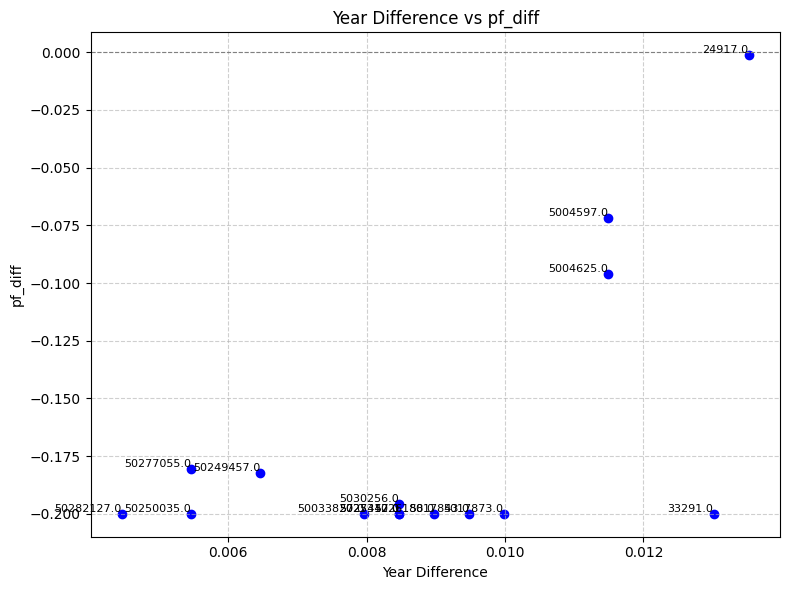

No non-zero values to plot for column 'ambient_bias_diff'.


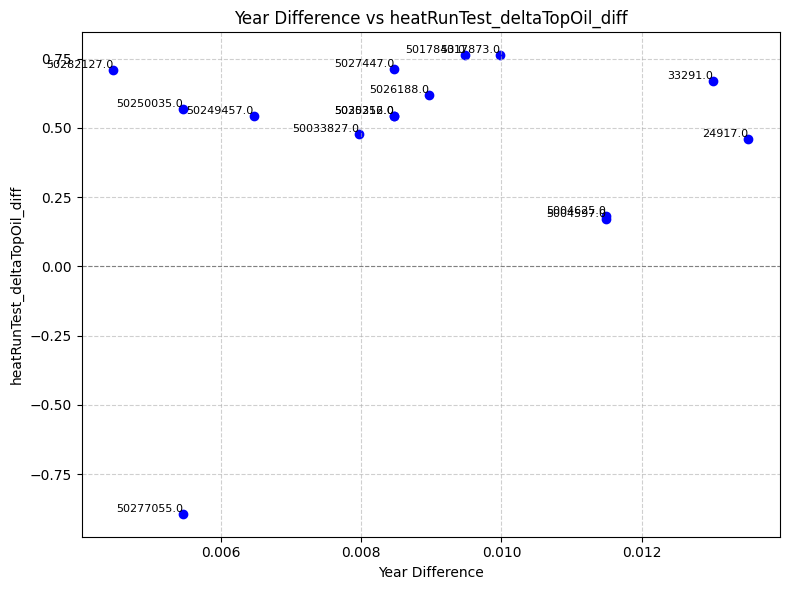

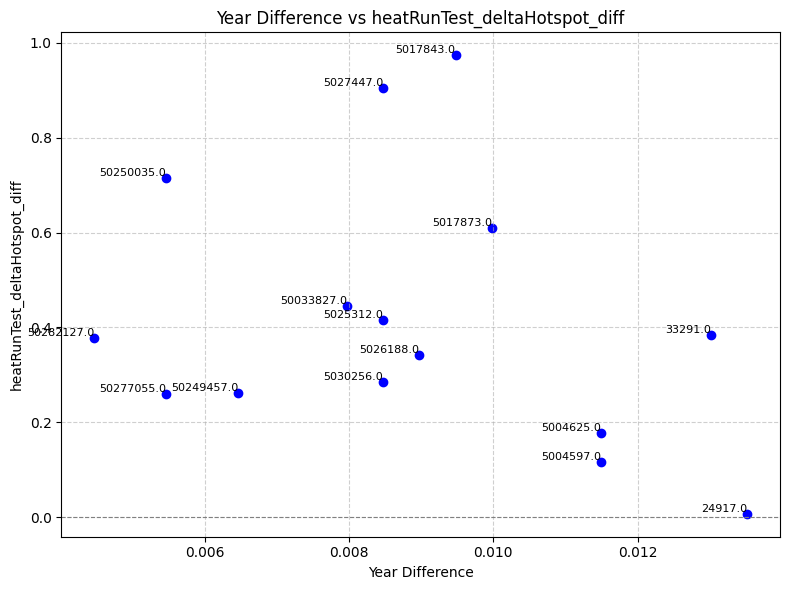

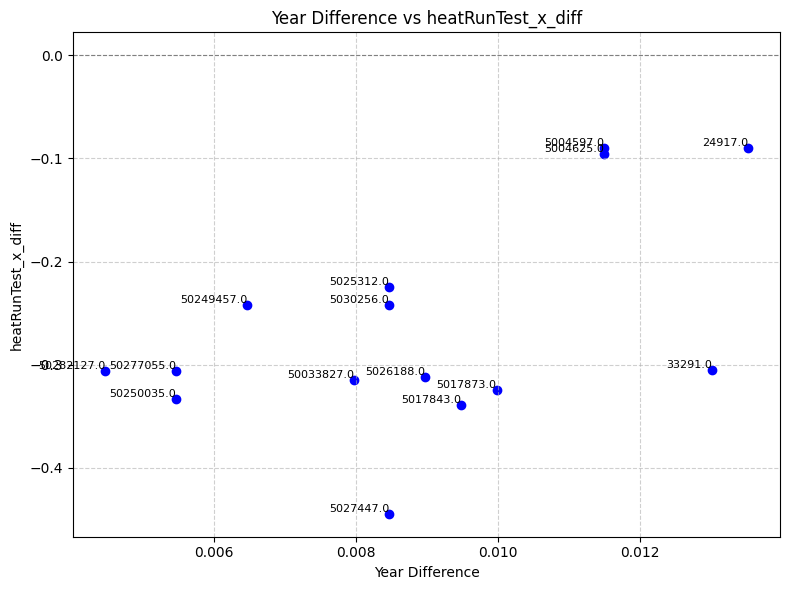

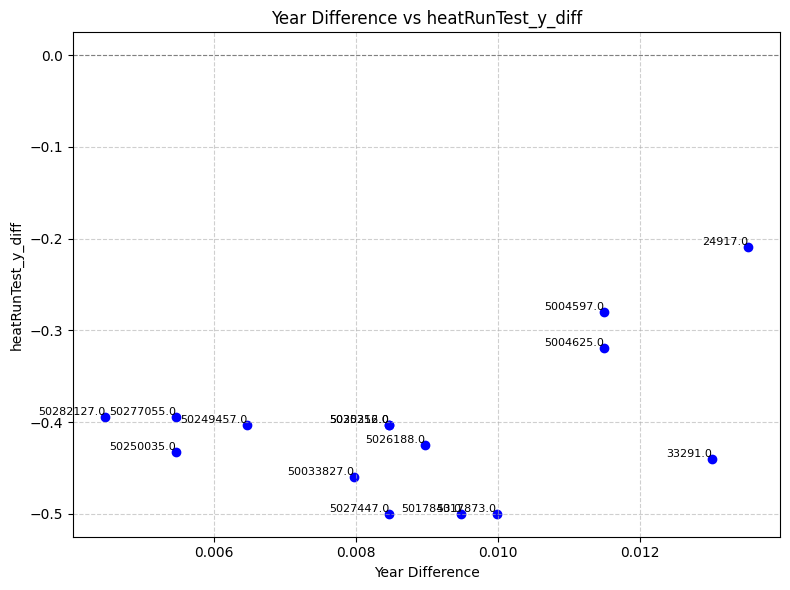

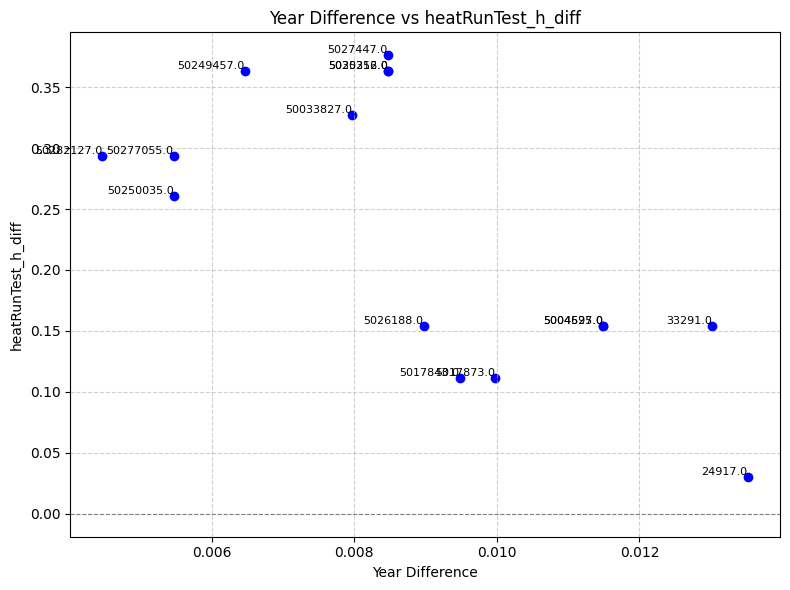

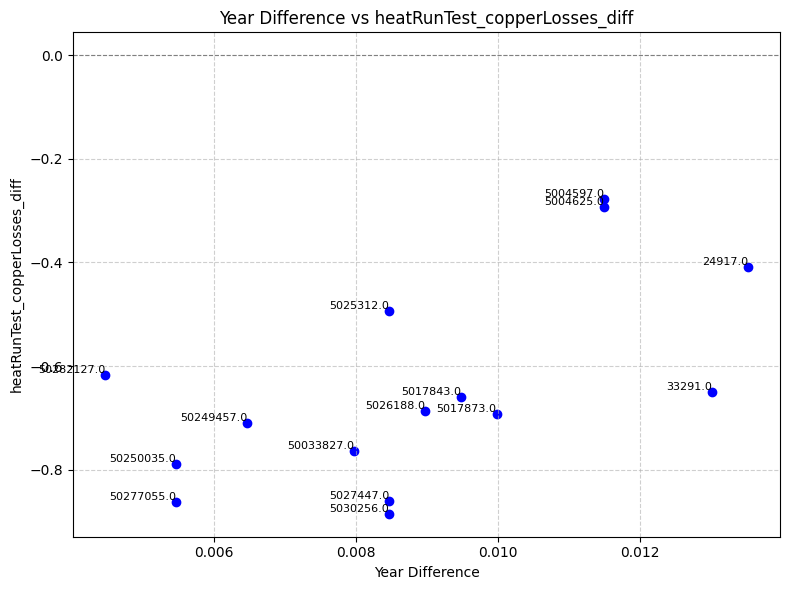

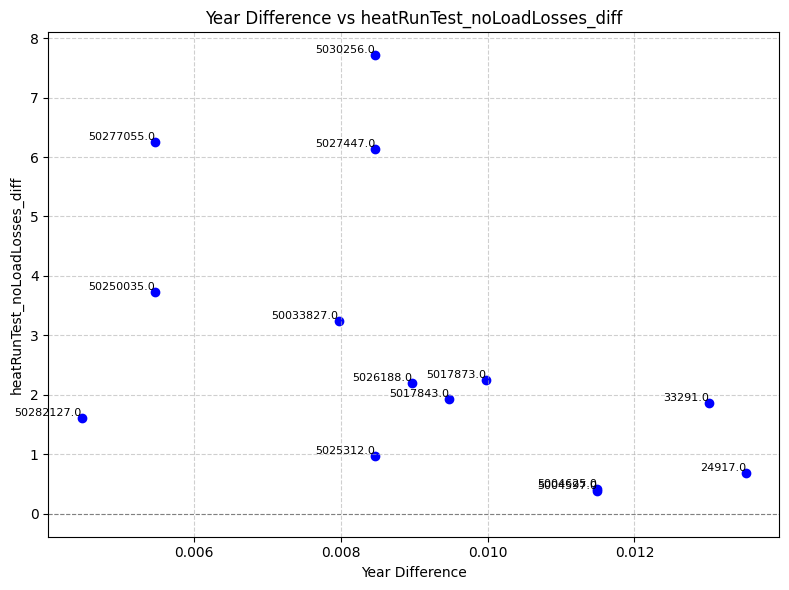

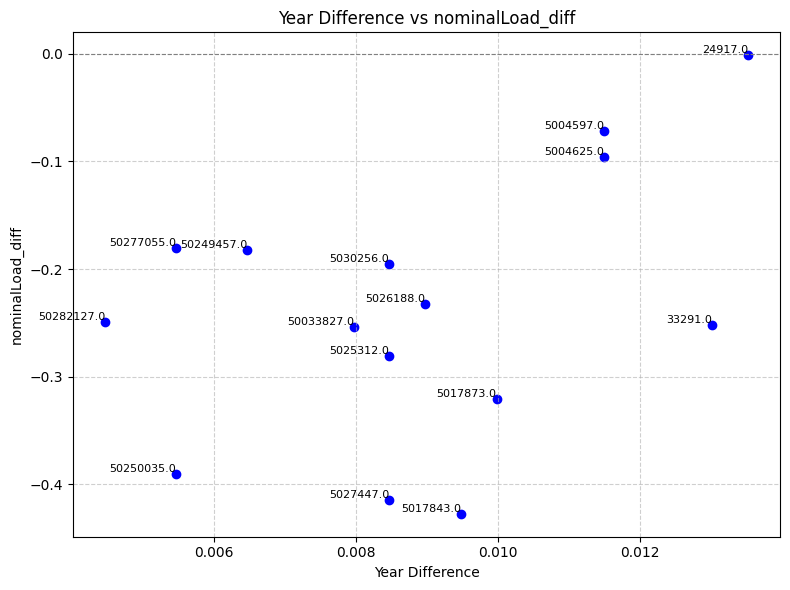

In [10]:
for key in keys:
    plot_differences(diff_df, f"{key}_diff")

In [ ]:
diff_df[]

,equipmentId,year_fit,year_og,year_diff,n,s_fit,pf_fit,ambient_bias_fit,heatRunTest_deltaTopOil_fit,heatRunTest_deltaHotspot_fit,...,heatRunTest_y_og,heatRunTest_h_og,heatRunTest_copperLosses_og,heatRunTest_noLoadLosses_og,nominalLoad_og,MAE_og,RMSE_og,Bias_og,R2_og,error
0,24917,2024.0,1997.0,27.0,14664.0,1.409274e-20,1.0,0.0,54.8,72.0,...,1.40,1.30,200.40,15.60,40.0,4.737509,5.781923,-1.573298,0.077263,NaN
1,33291,2024.0,1998.0,26.0,14664.0,3.778600e-21,1.0,0.0,47.9,65.4,...,1.43,1.30,244.30,19.97,50.0,6.079759,6.772061,-6.000365,-0.688981,NaN
2,5004597,2024.0,2001.0,23.0,14664.0,2.657593e-20,1.0,0.0,48.9,65.7,...,1.98,1.30,216.05,16.15,40.0,2.870896,4.253589,-1.876394,0.517259,NaN
3,5004625,2024.0,2001.0,23.0,14664.0,2.461954e-20,1.0,0.0,48.9,65.7,...,1.98,1.30,223.28,16.02,40.0,3.081849,4.448063,-1.927942,0.519663,NaN
4,5017843,2024.0,2005.0,19.0,14664.0,3.537076e-21,1.0,0.0,45.4,60.8,...,1.60,1.35,157.09,11.15,25.0,5.351348,5.765622,-5.330528,0.122334,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,50033827,2024.0,2008.0,16.0,14664.0,0.000000e+00,1.0,0.0,54.1,67.4,...,1.48,1.13,186.51,16.37,40.0,9.576920,10.420192,-9.557370,-2.694799,NaN
11,50249457,2024.0,2011.0,13.0,14664.0,0.000000e+00,1.0,0.0,51.9,67.7,...,1.34,1.10,106.30,9.50,25.0,7.619337,8.899493,-6.987041,-0.322698,NaN
12,50250035,2024.0,2013.0,11.0,14664.0,0.000000e+00,1.0,0.0,51.0,70.0,...,1.41,1.19,156.87,10.11,25.0,10.556226,11.458221,-10.525468,-1.802435,NaN
13,50277055,2024.0,2013.0,11.0,14664.0,0.000000e+00,1.0,0.0,46.8,62.8,...,1.32,1.16,149.18,15.51,40.0,10.418234,11.865488,-10.292295,-1.231761,NaN


In [12]:
def show_metric_diff(diff_df, metric="RMSE", tol=1e-4, verbose=True, known_params=None):
    """
    Print and summarize how a chosen metric changed vs OG, grouped by the combination
    of variables that were adjusted (|param_diff| >= tol).

    Parameters
    ----------
    diff_df : pd.DataFrame
        Output from compute_differences_vs_og(...) – must contain:
        - 'equipmentId'
        - 'year_diff' (optional but useful)
        - '{metric}_diff' column for the chosen metric
        - parameter diff columns like 's_diff', 'pf_diff', 'heatRunTest_x_diff', etc.
    metric : str
        Metric name, e.g., 'RMSE', 'MAE', 'Bias', 'R2'.
    tol : float
        Absolute tolerance to decide if a variable is considered "adjusted".
        Variables with |diff| >= tol are treated as adjusted.
    verbose : bool
        If True, prints a line per equipmentId.
    known_params : list[str] or None
        If provided, only consider these names (without the '_diff' suffix) as parameters.
        If None, all *_diff columns except the chosen metric and year_diff are treated as params.

    Returns
    -------
    details_df : pd.DataFrame
        Columns: equipmentId, year_diff (if present), metric_diff, adjusted_vars
    summary_df : pd.DataFrame
        Grouped by adjusted_vars with mean_metric_diff, std_metric_diff, count
    """
    import pandas as pd
    import numpy as np

    metric_col = f"{metric}_diff"
    if metric_col not in diff_df.columns:
        raise ValueError(f"Column '{metric_col}' not found in diff_df.")

    # Identify parameter diff columns
    if known_params is not None:
        param_diff_cols = [f"{p}_diff" for p in known_params if f"{p}_diff" in diff_df.columns]
    else:
        # take all *_diff except the chosen metric and year_diff
        param_diff_cols = [
            c for c in diff_df.columns
            if c.endswith("_diff") and c not in {metric_col, "year_diff"}
        ]

    # Build details rows
    records = []
    for _, row in diff_df.iterrows():
        # which params are "adjusted"?
        adjusted = []
        for c in param_diff_cols:
            val = row[c]
            if pd.notna(val) and abs(val) >= tol:
                adjusted.append(c[:-5])  # strip '_diff' suffix

        adjusted_vars = ",".join(sorted(adjusted)) if adjusted else "(none)"
        rec = {
            "equipmentId": row["equipmentId"],
            "metric_diff": row[metric_col],
            "adjusted_vars": adjusted_vars
        }
        if "year_diff" in diff_df.columns:
            rec["year_diff"] = row["year_diff"]
        records.append(rec)

        if verbose:
            yd_txt = f", Δyears={int(row['year_diff'])}" if "year_diff" in rec and pd.notna(rec["year_diff"]) else ""
            print(f"{row['equipmentId']}: Δ{metric}={row[metric_col]:.4f}{yd_txt} | adjusted: {adjusted_vars}")

    details_df = pd.DataFrame(records)

    # Summary by combination
    agg_dict = {"metric_diff": ["mean", "std", "count"]}
    summary = (
        details_df.groupby("adjusted_vars", dropna=False)["metric_diff"]
        .agg(["mean", "std", "count"])
        .reset_index()
        .rename(columns={"mean": "mean_metric_diff", "std": "std_metric_diff", "count": "count"})
        .sort_values(["count", "mean_metric_diff"], ascending=[False, True])
        .reset_index(drop=True)
    )

    return details_df, summary


In [25]:
details, summary = show_metric_diff(diff_df, metric="MAE", tol=1e-4, verbose=True, known_params=keys)

24917.0: ΔMAE=0.0000, Δyears=27 | adjusted: (none)
33291.0: ΔMAE=0.0000, Δyears=26 | adjusted: (none)
5004597.0: ΔMAE=0.0000, Δyears=23 | adjusted: (none)
5004625.0: ΔMAE=0.0000, Δyears=23 | adjusted: (none)
5017843.0: ΔMAE=0.0000, Δyears=19 | adjusted: (none)
5017873.0: ΔMAE=0.0000, Δyears=20 | adjusted: (none)
5025312.0: ΔMAE=0.0000, Δyears=17 | adjusted: (none)
5026188.0: ΔMAE=0.0000, Δyears=18 | adjusted: (none)
5027447.0: ΔMAE=0.0000, Δyears=17 | adjusted: (none)
5030256.0: ΔMAE=0.0000, Δyears=17 | adjusted: (none)
50033827.0: ΔMAE=0.0000, Δyears=16 | adjusted: (none)
50249457.0: ΔMAE=0.0000, Δyears=13 | adjusted: (none)
50250035.0: ΔMAE=0.0000, Δyears=11 | adjusted: (none)
50277055.0: ΔMAE=0.0000, Δyears=11 | adjusted: (none)
50282127.0: ΔMAE=0.0000, Δyears=9 | adjusted: (none)
24917.0: ΔMAE=0.0000, Δyears=27 | adjusted: pf
33291.0: ΔMAE=-0.2353, Δyears=26 | adjusted: pf
5004597.0: ΔMAE=-0.0122, Δyears=23 | adjusted: pf
5004625.0: ΔMAE=-0.0181, Δyears=23 | adjusted: pf
5017843.0:

In [26]:
summary

,adjusted_vars,mean_metric_diff,std_metric_diff,count
0,(none),-0.200836,0.241182,30
1,heatRunTest_copperLosses,-0.499650,0.214660,15
2,heatRunTest_x,-0.435259,0.201494,15
3,heatRunTest_y,-0.268505,0.146380,15
4,heatRunTest_deltaHotspot,-0.266460,0.150860,15
5,nominalLoad,-0.250634,0.144933,15
6,pf,-0.208592,0.135711,15
7,heatRunTest_deltaTopOil,-0.196473,0.132536,15
8,heatRunTest_h,-0.077454,0.069953,15
9,heatRunTest_noLoadLosses,-0.503485,0.222229,14


In [15]:
diff_df

,equipmentId,year_diff,year_fit,year_og,s_diff,pf_diff,ambient_bias_diff,heatRunTest_deltaTopOil_diff,heatRunTest_deltaHotspot_diff,heatRunTest_x_diff,heatRunTest_y_diff,heatRunTest_h_diff,heatRunTest_copperLosses_diff,heatRunTest_noLoadLosses_diff,nominalLoad_diff,MAE_diff,RMSE_diff,Bias_diff,R2_diff
0,24917,0.013520,2024.0,1997.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
1,33291,0.013013,2024.0,1998.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,-0.000000
2,5004597,0.011494,2024.0,2001.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
3,5004625,0.011494,2024.0,2001.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
4,5017843,0.009476,2024.0,2005.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,-0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,50033827,0.007968,2024.0,2008.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.254073,-0.385914,-0.332610,-0.714154,-0.760392
11,50249457,0.006464,2024.0,2011.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.182130,-0.264428,-0.244080,-0.689343,-1.756714
12,50250035,0.005464,2024.0,2013.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.390791,-0.294109,-0.211968,-0.462801,-0.589279
13,50277055,0.005464,2024.0,2013.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.180497,-0.401295,-0.355806,-0.813446,-1.059956
